# Обработка данных нейтрализации Spike-псевдотипированных лентивирусов

## 1. Открывание файлов с данными

### 1.1. Получение списка файлов с данными в определённой директории

In [ ]:
import pandas as pd
import os
import re


class OpenData(object):

    def __init__(self, path) -> None:
        self.path = path

    def check_filename_format(self, filename):
        # Регулярное выражение для проверки формата
        pattern = re.compile(r'^[A-Za-z0-9]+_[A-Za-z0-9.]+_\d{2}\.\d{2}\.\d{4}\.xlsx$')

        # Проверка соответствия формату
        if pattern.match(filename):
            return True
        else:
            return False

    def readFiles(self):
        files = {}
        for file in os.listdir(self.path):
            if "xlsx" in file:
                files[file] = self.path+'\\'+file

        return files
    
prefix = "C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\"
dt = OpenData(path = prefix)
files = dt.readFiles()
files

### 1.2. Обработка названий (исправление названий антител)

In [ ]:
import pandas as pd
from datetime import datetime

class MergeData(object):

    def __init__(self, files):
        self.file = files

    def openDataFrames(self, files):
        self.dataframes = {}
        for key, value in files.items():
            self.dataframes[key] = pd.read_excel(value)
            self.dataframes[key].columns =  self.dataframes[key].columns.astype(str)

    def parseDataColumns(self):
        for key, value in self.dataframes.items():
            new_cols = {}
            for col in value.columns:
                if '-tetra' in col:
                    new_col = col.replace('tetra', 'Gs')
                    if '-Fc' in col:
                        new_col = new_col.replace('-Fc', '')
                    new_cols[col] = new_col
            if len(new_cols) > 0:
                self.dataframes[key] = value.rename(columns = new_cols)

        for key, value in self.dataframes.items():
            new_cols = {}
            for col in value.columns:
                if '-bis' in col:
                    new_col = col.replace('-bis', '')
                    new_cols[col] = new_col
            if len(new_cols) > 0:
                self.dataframes[key] = value.rename(columns = new_cols)

        for key, value in self.dataframes.items():
            new_cols = {}
            for col in value.columns:
                if 'Gs' not in col:
                    if '58-57' in col:
                        new_col = col.replace('58-57', '57-58')
                        new_cols[col] = new_col
                    if '57-21' in col:
                        new_col = col.replace('57-21', '21-57')
                        new_cols[col] = new_col
                    if '57-7' in col:
                        new_col = col.replace('57-7', '7-57')
                        new_cols[col] = new_col
                    if '21-7' in col:
                        new_col = col.replace('21-7', '7-21')
                        new_cols[col] = new_col
                    if '58-7' in col:
                        new_col = col.replace('58-7', '7-58')
                        new_cols[col] = new_col
                    if '58-21' in col:
                        new_col = col.replace('58-21', '21-58')
                        new_cols[col] = new_col
            if len(new_cols) > 0:
                self.dataframes[key] = value.rename(columns = new_cols)
    
    def parseFileNames(self):
        self.names = {}
        for key in self.dataframes.keys():
            self.names[key] = key.replace('BsAb_', '').replace('mono_', '').replace('homo_', '').replace('_', ' ').replace('.xlsx', '')

    def process_dict(self, data):
        df = pd.DataFrame(columns=['serum', 'date'])

        for key, value in data.items():
            parts = value.split(' ')

            date = parts[-1]

            virus = ' '.join(parts[:-1])

            if ' III' in virus:
                virus = virus.replace(' III', '')

            if ' II' in virus:
                virus = virus.replace(' II', '')

            if ' I' in virus:
                virus = virus.replace(' I', '')

            df.loc[key] = [virus, date]

        return df
    
    def parseMultipleDfs(self, dfs):
        parsedDfs = []
        for name, df in dfs.items():
            for col in df.columns:
                if "." in col:
                    spl_col = col.split(".")[0]
                    df[spl_col] = (df[spl_col] + df[col]) / 2
                    df = df.drop(columns = [col])
            parsedDfs.append(self.parseDf(df, name))

        return pd.concat(parsedDfs, axis=0, ignore_index=True)

    def  parseDf(self, df, name):
        dfs = []
        for col in df.columns:
            if col != 'X':
                dfs.append(self.createDfPerColumn(df[col], col, df['X'], name))

        return pd.concat(dfs, axis=0, ignore_index=True)

    def createDfPerColumn(self, df_col, col_name, x_col, virus):
        return pd.DataFrame(data={
            'virus': [col_name for _ in range(len(df_col))],
            'serum': [virus for _ in range(len(df_col))],
            'replicate': [1 for _ in range(len(df_col))],
            'concentration': x_col.values,
            'fraction infectivity': df_col.values,
        })
    
    def processViruses(self, dataframe, parsedVirusNames):
        dataframe = dataframe.merge(parsedVirusNames, left_on='serum', right_index=True, suffixes=('', '_new'))
        dataframe['serum'] = dataframe['serum_new']
        dataframe.drop(columns=['serum_new'], inplace=True)
        return dataframe
    
    def generate_process_combinations(self, dataframe):
        combinations = []
        for i in range(len(dataframe)):
            combinations.append((dataframe.loc[i, 'serum'], dataframe.loc[i, 'virus']))
        
        self.combinations = list(set(combinations))

    def create_serum_virus_dict(self, dataframe):
        serum_virus_dict = {}
        for _, row in dataframe.iterrows():
            serum = row['serum']
            virus = row['virus']
            if serum not in serum_virus_dict:
                serum_virus_dict[serum] = {}
            serum_virus_dict[serum][virus] = True
        return serum_virus_dict
    
    def normalize_dataframes(self):
        normalized = {}

        for name, df in self.dataframes.items():
            df_norm = df.copy()

            for col in df_norm.columns:
                if col == "X":
                    continue

                col_min = df_norm[col].min(skipna=True)
                col_max = df_norm[col].max(skipna=True)

                # защита от деления на 0 (если все значения одинаковые)
                if col_max != col_min:
                    df_norm[col] = (df_norm[col] - col_min) / (col_max - col_min) * 100
                else:
                    df_norm[col] = 0.0

            normalized[name] = df_norm

        self.dataframes = normalized

    def process_replicates(self, dataframe):
        dct = {}

        for combo in self.combinations:
            if len(set(dataframe[(dataframe['serum'] == combo[0]) & (dataframe['virus'] == combo[1])]['date'].values)) > 1:
                # print([date for date in list(set(dataframe[(dataframe['serum'] == combo[0]) & (dataframe['virus'] == combo[1])]['date'].values))])
                date_objects = [datetime.strptime(date, '%d.%m.%Y') for date in list(set(dataframe[(dataframe['serum'] == combo[0]) & (dataframe['virus'] == combo[1])]['date'].values))]
                sorted_dates = sorted(date_objects)
                numbered_dates = {date.strftime('%d.%m.%Y'): i + 1 for i, date in enumerate(sorted_dates)}
                for key, val in numbered_dates.items():
                    dct[(combo[0], combo[1], key)] = val

        for key, value in dct.items():
            for idx in dataframe[(dataframe['serum'] == key[0]) & (dataframe['virus'] == key[1]) & (dataframe['date'] == key[2])].index:
                dataframe.loc[idx, 'replicate'] = int(value)
    
parsed_dict = {}
for file, path in files.items():
    d = {file: path}
    dt = MergeData(files=d)
    dt.openDataFrames(files=d)
    dt.parseDataColumns()
    dt.parseFileNames()
    new_virus_names = dt.process_dict(data=dt.names)
    # dt.normalize_dataframes()
    merged_data = dt.parseMultipleDfs(dt.dataframes)
    df = dt.processViruses(merged_data, new_virus_names)
    parsed_dict[file] = df


## 2. Детекция плато и нормализация данных

    Нормализация данных
Для каждого файла рассчитывались параметры нейтрализационных кривых двумя способами:
	
    Индивидуальная нормализация (Individual normalization) — значения доли инфекции нормализовались для каждого serum (антитела) отдельно. Если $f_{ij}$ — доля инфекции для концентрации serum, то нормализованное значение вычислялось как:
$$
f_{ij}^{\rm{norm,ind}}=\frac{f_{ij}-f_j^{min}}{f_j^{max}-f_j^{min}}
$$
где  $f_j^{min}$ и $f_j^{max}$ — минимальное и максимальное значение доли инфекции для $serum_{j}$

$$
f_j^{min}=\min_{\scriptstyle{i}}{f_{ij}},\\ f_j^{max}=\max_{\scriptstyle{i}}{f_{ij}}
$$
	Глобальная нормализация (Global normalization) — значения доли инфекции нормализовались по всему файлу:
$$
f_{ij}^{\rm{norm,global}}=\frac{f_{ij}-f_{\rm{global}}^{min}}{f_{\rm{global}}^{max}-f_{\rm{global}}^{min}}
$$
Где
$$
f_{\rm{global}}^{min}=\min_{\scriptstyle{i, j}}{f_{ij}},\\ f_{\rm{global}}^{max}=\max_{\scriptstyle{i, j}}{f_{ij}}
$$
Оба подхода позволяли привести значения доли инфекции к диапазону [0,1], однако различались в том, какие данные использовались для масштабирования: индивидуальная нормализация учитывала только конкретный serum, что давало более чувствительную оценку его активности, а глобальная — все эксперименты файла, что уменьшало влияние локальных вариаций.
Коррекция плато
Для обеих нормализаций применялся метод snap-to-plateau, предназначенный для корректировки верхнего и нижнего плато кривой:
- Все значения после выхода на плато верхнего уровня приравнивались к 1.
- Все значения до плато нижнего уровня приравнивались к 0.
- Промежуточные значения оставались неизменными, что сохраняло форму кривой и учитывало реальный динамический диапазон активности серума.
$$
\left\{
    \begin{array}{l}
    f_{ij}^{\rm{norm,snapped}}=\rm{0\ if\ }f_{ij}^{\rm{norm}}\leq{f}_{\rm{plateau,min}},\\
    {1}\ if\ f_{ij}^{\rm{norm}}\geq{f}_{\rm{plateau,max}},\\
    {otherwise\ }f_{ij}^{\rm{norm}}
    \end{array}
\right.
$$
Это позволило устранить искажения, вызванные шумом в верхней и нижней частях кривой, и сделать нормализацию более биологически корректной.
Примечания по реализации
- Если максимальное или минимальное значение совпадало (т.е. плоская кривая), нормализация не проводилась, а результат помечался как NaN.
- Нормализованные значения сохранялись в отдельную колонку: fraction infectivity_norm.
- Исходные значения сохранялись для возможности визуальной проверки и построения кривых без потери данных.
Все объекты DataFrame с обработанными данными также добавлялись в словарь с ключами, соответствующими названиям файлов, к которым они принадлежали.

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Any, Optional, List

class PlateauNormalizer:
    def __init__(
        self,
        serum_col: str,
        conc_col: str,
        val_col: str,
        use_minmax_scaler: bool = True,
        use_plateau_snap: bool = True,
        plateau_eps: float = 0.02,
        clip: bool = True,
    ):
        self.serum_col = serum_col
        self.conc_col = conc_col
        self.val_col = val_col
        self.use_minmax_scaler = use_minmax_scaler
        self.use_plateau_snap = use_plateau_snap
        self.plateau_eps = plateau_eps
        self.clip = clip

    def _snap_to_plateau(self, norm_values: np.ndarray) -> np.ndarray:
        eps = self.plateau_eps
        norm_values = norm_values.copy()

        # --- верхнее плато ---
        high = norm_values >= (1 - eps)
        if high.any():
            first_high = np.argmax(high)
            norm_values[first_high:] = 1.0

        # --- нижнее плато (консервативно) ---
        low = norm_values <= eps
        if low.any():
            first_low = np.argmax(low)
            tail = norm_values[first_low:]
            if np.all(np.diff(tail) <= eps):
                norm_values[:first_low + 1] = 0.0

        return norm_values

    # --------------------
    # Helper functions (unchanged)
    # --------------------
    def _tol(self, median_val: float) -> float:
        return max(self.abs_tol, abs(median_val) * self.rel_tol)
    
    def _serum_trend_ok(self, concs: np.ndarray, vals: np.ndarray) -> bool:
        try:
            concs = np.asarray(concs, dtype=float)
            vals = np.asarray(vals, dtype=float)
        except Exception:
            return True

        n = len(vals)
        if n < 3:
            return True

        order = np.argsort(concs)[::-1]
        v_sorted = vals[order]

        diffs = np.diff(v_sorted)
        n_steps = len(diffs)
        if n_steps == 0:
            return True

        n_increases = np.sum(diffs > 0)
        frac_increase = float(n_increases) / float(n_steps)

        return frac_increase >= float(self.min_frac_increasing)

    def _find_plateau_from_edge(self, arr: np.ndarray, from_start: bool = True) -> Optional[Dict[str, Any]]:
        if not from_start:
            arr = arr[::-1]

        n = len(arr)
        if n < self.min_plateau_len:
            return None

        window_idx = list(range(self.min_plateau_len))
        window_vals = arr[window_idx]
        if np.all(np.isnan(window_vals)):
            return None
        med = float(np.nanmedian(window_vals))
        mad = float(np.nanmedian(np.abs(window_vals - med))) if np.any(~np.isnan(window_vals)) else 0.0

        outlier_count = 0
        for i in range(self.min_plateau_len, n):
            v = arr[i]
            if np.isnan(v):
                break
            if abs(v - med) <= self._tol(med):
                window_idx.append(i)
                vals = arr[window_idx]
                med = float(np.nanmedian(vals))
                mad = float(np.nanmedian(np.abs(vals - med)))
            else:
                outlier_count += 1
                if outlier_count <= self.allow_outliers:
                    window_idx.append(i)
                    vals = arr[window_idx]
                    med = float(np.nanmedian(vals))
                    mad = float(np.nanmedian(np.abs(vals - med)))
                else:
                    break

        if len(window_idx) < self.min_plateau_len:
            return None

        if from_start:
            indices = window_idx
        else:
            indices = [n - 1 - idx for idx in window_idx[::-1]]

        plateau_vals = arr[window_idx]
        if np.all(np.isnan(plateau_vals)):
            return None
        final_med = float(np.nanmedian(plateau_vals))
        final_mad = float(np.nanmedian(np.abs(plateau_vals - final_med))) if np.any(~np.isnan(plateau_vals)) else 0.0

        return {'indices': indices, 'median': final_med, 'mad': final_mad, 'length': len(indices)}
    
    def _passes_min_infectivity_qc(self, df: pd.DataFrame, threshold: float = 50.0) -> bool:
        if df.empty:
            return False

        tmp = df.dropna(subset=[self.serum_col, self.val_col])
        if tmp.empty:
            return False

        max_per_serum = (
            tmp
            .groupby(self.serum_col)[self.val_col]
            .max()
        )

        if max_per_serum.empty:
            return False

        return not (max_per_serum < threshold).all()

    def _get_plateau_or_fallback(self, vals: np.ndarray, from_start: bool):
        strict = self._find_plateau_from_edge(vals, from_start=from_start)
        if strict is not None:
            return strict | {'source': 'strict'}

        if len(vals) >= 2:
            pts = vals[:2] if from_start else vals[-2:]
            return {
                'median': float(np.nanmean(pts)),
                'length': 2,
                'source': 'fallback_2'
            }

        if len(vals) == 1:
            return {
                'median': float(vals[0]),
                'length': 1,
                'source': 'fallback_1'
            }

        return None

    @staticmethod
    def _weighted_median(values: List[float], weights: List[float]) -> Optional[float]:
        values = np.asarray(values)
        weights = np.asarray(weights, dtype=float)
        if len(values) == 0:
            return None
        order = np.argsort(values)
        v_sorted = values[order]
        w_sorted = weights[order]
        cumw = np.cumsum(w_sorted)
        cutoff = cumw[-1] / 2.0
        idx = np.searchsorted(cumw, cutoff)
        return float(v_sorted[min(idx, len(v_sorted) - 1)])

    # --------------------
    # New: MinMax scaler helper
    # --------------------
    def _minmax_scale_series(self, s: pd.Series) -> Tuple[pd.Series, float, float]:
        """
        Масштабирует Series в [0,1] по правилу (x - min)/(max-min).
        Если max == min -> возвращается Series заполненный NaN (не можем масштабировать),
        но можно также вернуть 0.0; здесь возвращаю NaN, чтобы сигнализировать, что
        группа непригодна для нормализации.
        Возвращает (scaled_series, min_val, max_val)
        """
        s_float = s.astype(float)
        valid = s_float.dropna()
        if valid.empty:
            return pd.Series(np.nan, index=s.index), np.nan, np.nan
        vmin = float(np.nanmin(valid))
        vmax = float(np.nanmax(valid))
        if np.isclose(vmax, vmin):
            # Нельзя масштабировать — все значения одинаковы
            return pd.Series(np.nan, index=s.index), vmin, vmax
        scaled = (s_float - vmin) / (vmax - vmin)
        if self.clip:
            scaled = scaled.clip(0.0, 1.0)
        return scaled, vmin, vmax

    # --------------------
    # Processing methods (modified to support use_minmax_scaler)
    # --------------------
    def process_dataframe_global(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
        df = df.copy()
        df = df.dropna(subset=[self.conc_col, self.val_col]).copy()
        df[self.conc_col] = pd.to_numeric(df[self.conc_col], errors='coerce')
        df[self.val_col] = pd.to_numeric(df[self.val_col], errors='coerce')

        norm_col = f"{self.val_col}_norm"
        snapped_col = f"{self.val_col}_snapped"

        # Если включен minmax scaler — масштабируем весь датафрейм простым min/max
        if self.use_minmax_scaler:
            s_all = df[self.val_col].astype(float)
            scaled, vmin, vmax = self._minmax_scale_series(s_all)
            df[snapped_col] = df[self.val_col].astype(float)  # не изменяем исходные значения
            df[norm_col] = scaled

            # report
            report_df = pd.DataFrame({
                'metric': ['global_min', 'global_max'],
                'value': [vmin, vmax]
            })
            plateaus_info = {
                'chosen_lower': vmin,
                'chosen_upper': vmax,
                'mode': 'minmax_global'
            }
            return df, report_df, plateaus_info

        # ---- legacy plateau-based path (как было раньше) ----
        values = df[self.val_col].dropna()
        chosen_lower = float(np.nanpercentile(values, self.fallback_lower_pct))
        chosen_upper = float(np.nanmax(values))
        if np.isclose(chosen_upper, chosen_lower):
            chosen_lower = float(np.nanmin(values))
            chosen_upper = float(np.nanmax(values))

        s = df[self.val_col].astype(float)
        s = self._snap_to_plateau(plateau_type="global", series=s, plateau_value=chosen_lower)
        s = self._snap_to_plateau(plateau_type="global", series=s, plateau_value=chosen_upper)
        df[snapped_col] = s

        denom = chosen_upper - chosen_lower
        if denom == 0:
            denom = 1.0

        df[norm_col] = (s - chosen_lower) / denom
        if self.clip:
            df[norm_col] = df[norm_col].clip(0.0, 1.0)

        report_df = pd.DataFrame({
            'metric': ['lower', 'upper'],
            'value': [chosen_lower, chosen_upper]
        })
        plateaus_info = {
            'chosen_lower': chosen_lower,
            'chosen_upper': chosen_upper,
            'mode': 'legacy_global'
        }
        return df, report_df, plateaus_info


    def process_dataframe_individual(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
        df = df.copy()
        df = df.dropna(subset=[self.conc_col, self.val_col])
        df[self.conc_col] = pd.to_numeric(df[self.conc_col], errors='coerce')
        df[self.val_col] = pd.to_numeric(df[self.val_col], errors='coerce')

        norm_col = f"{self.val_col}_norm"
        snapped_col = f"{self.val_col}_snapped"
        df[norm_col] = np.nan
        df[snapped_col] = df[self.val_col].astype(float)

        # Ветвление: либо используем minmax scaler, либо плато-алгоритм
        if self.use_minmax_scaler:
            for serum, group in df.groupby(self.serum_col):
                idx = group.index
                values = group[self.val_col].astype(float)

                vmin = values.min()
                vmax = values.max()

                if pd.isna(vmin) or pd.isna(vmax) or np.isclose(vmin, vmax):
                    df.loc[idx, norm_col] = np.nan
                    continue

                norm_values = (values - vmin) / (vmax - vmin)

                if self.use_plateau_snap:
                    norm_values = self._snap_to_plateau(norm_values.values)

                df.loc[idx, norm_col] = norm_values
                df.loc[idx, snapped_col] = values.values


            report_df = (
                df
                .groupby(self.serum_col)[self.val_col]
                .agg(['min', 'max', 'count'])
                .reset_index()
                .rename(columns={self.serum_col: 'serum_id'})
            )

            plateaus_info = {
                'n_serums_total': report_df.shape[0],
                'n_serums_used_for_norm': int((report_df['max'] > report_df['min']).sum()),
                'mode': 'minmax_individual + plateau_snap',
                'plateau_eps': self.plateau_eps
            }

            return df, report_df, plateaus_info

    # --------------------
    # Public runner (unchanged)
    # --------------------
    def run_on_parsed_dict(self, parsed_dict: Dict[str, pd.DataFrame], variant: str = 'global') -> Tuple[Dict[str, pd.DataFrame], Dict[str, Any]]:
        assert variant in ('global', 'individual'), "variant must be 'global' or 'individual'"
        processed = {}
        reports = {}

        for key, df_leg in parsed_dict.items():
            print(f"Processing {key} ...")
            df = df_leg.copy()
            df["serum"], df["virus"] = df["virus"], df["serum"]

            if not self._passes_min_infectivity_qc(df, threshold=50.0):
                print("  QC failed: no serum reaches 50% infectivity -> skip entire DataFrame.\n")
                continue

            try:
                if variant == 'global':
                    df_norm, report_df, plateaus_info = self.process_dataframe_global(df)
                else:
                    df_norm, report_df, plateaus_info = self.process_dataframe_individual(df)

                if (variant == 'individual') and df_norm.empty:
                    print("  No valid serums left after filtering -> skip entire DataFrame.\n")
                    continue

                processed[key] = df_norm
                reports[key] = {
                    'report_df': report_df,
                    'plateaus_info': plateaus_info
                }

                if variant == 'global':
                    if 'chosen_lower' in plateaus_info:
                        print(
                            f"  Global lower: {plateaus_info['chosen_lower']:.3f}, upper: {plateaus_info['chosen_upper']:.3f}\n"
                        )
                    else:
                        print("  Global normalization done.\n")
                else:
                    print(f"  Serums total: {plateaus_info.get('n_serums_total', 0)}, used for norm: {plateaus_info.get('n_serums_used_for_norm', 0)}\n")

            except Exception as e:
                print(f"  ERROR processing {key}: {e}\n")
                continue

        return processed, reports



# --------------------
# Пример использования:
# --------------------
if __name__ == "__main__":
    # настройте нормализатор:
    normalizer = PlateauNormalizer(
        serum_col='serum',
        conc_col='concentration',
        val_col='fraction infectivity',
        use_minmax_scaler=True,
    )

    # Запустить в global-режиме:
    parsed_dict_norm_global, reports_global = normalizer.run_on_parsed_dict(parsed_dict, variant='global')

    # Или запустить в individual-режиме:
    parsed_dict_norm_ind, reports_ind = normalizer.run_on_parsed_dict(parsed_dict, variant='individual')

Processing BsAb_BA.1_06.06.2024.xlsx ...
  Global lower: -0.249, upper: 70.341

Processing BsAb_BA.1_14.05.2024.xlsx ...
  Global lower: -0.226, upper: 84.873

Processing BsAb_BA.1_28.12.2023.xlsx ...
  Global lower: -1.743, upper: 114.107

Processing BsAb_BA.2_06.06.2024.xlsx ...
  Global lower: -0.199, upper: 72.660

Processing BsAb_BA.2_14.05.2024.xlsx ...
  Global lower: -0.500, upper: 134.630

Processing BsAb_BA.2_28.12.2023.xlsx ...
  Global lower: -3.562, upper: 163.687

Processing BsAb_BA.45_06.06.2024.xlsx ...
  Global lower: 0.013, upper: 78.749

Processing BsAb_BA.45_14.05.2024.xlsx ...
  Global lower: -1.681, upper: 158.615

Processing BsAb_BA.45_19.07.2024.xlsx ...
  Global lower: -0.727, upper: 184.114

Processing BsAb_BA.45_25.01.2024.xlsx ...
  Global lower: -0.226, upper: 153.824

Processing BsAb_BA.45_28.12.2023.xlsx ...
  Global lower: -1.167, upper: 110.255

Processing BsAb_BQ.1_06.06.2024.xlsx ...
  Global lower: -0.790, upper: 107.126

Processing BsAb_BQ.1_14.05.2

In [ ]:
parsed_dict_norm_global["BsAb_BA.2_14.05.2024.xlsx"]

,virus,serum,replicate,concentration,fraction infectivity,date,fraction infectivity_snapped,fraction infectivity_norm
0,BA.2,7-57-Fc,1,4000.00000,0.185631,14.05.2024,0.185631,0.005075
1,BA.2,7-57-Fc,1,2000.00000,0.175534,14.05.2024,0.175534,0.005001
2,BA.2,7-57-Fc,1,1000.00000,0.061877,14.05.2024,0.061877,0.004159
3,BA.2,7-57-Fc,1,500.00000,1.547961,14.05.2024,1.547961,0.015157
4,BA.2,7-57-Fc,1,250.00000,7.145631,14.05.2024,7.145631,0.056581
5,BA.2,7-57-Fc,1,125.00000,24.002590,14.05.2024,24.002590,0.181327
6,BA.2,7-57-Fc,1,62.50000,34.878960,14.05.2024,34.878960,0.261815
7,BA.2,7-57-Fc,1,31.25000,65.685440,14.05.2024,65.685440,0.489790
8,BA.2,7-57-Fc,1,15.62500,112.261500,14.05.2024,112.261500,0.834465
9,BA.2,7-57-Fc,1,7.81250,103.070600,14.05.2024,103.070600,0.766450


In [10]:
parsed_dict_norm_ind["BsAb_BA.2_14.05.2024.xlsx"]

,virus,serum,replicate,concentration,fraction infectivity,date,fraction infectivity_norm,fraction infectivity_snapped
0,BA.2,7-57-Fc,1,4000.00000,0.185631,14.05.2024,0.000920,0.185631
1,BA.2,7-57-Fc,1,2000.00000,0.175534,14.05.2024,0.000845,0.175534
2,BA.2,7-57-Fc,1,1000.00000,0.061877,14.05.2024,0.000000,0.061877
3,BA.2,7-57-Fc,1,500.00000,1.547961,14.05.2024,0.011043,1.547961
4,BA.2,7-57-Fc,1,250.00000,7.145631,14.05.2024,0.052640,7.145631
5,BA.2,7-57-Fc,1,125.00000,24.002590,14.05.2024,0.177907,24.002590
6,BA.2,7-57-Fc,1,62.50000,34.878960,14.05.2024,0.258731,34.878960
7,BA.2,7-57-Fc,1,31.25000,65.685440,14.05.2024,0.487659,65.685440
8,BA.2,7-57-Fc,1,15.62500,112.261500,14.05.2024,0.833773,112.261500
9,BA.2,7-57-Fc,1,7.81250,103.070600,14.05.2024,0.765474,103.070600


## 3. Построение графиков по данным, нормализованных индивидуально для каждого антитела, а также глобально для всего эксперимента

In [ ]:
import os
import 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from matplotlib.lines import Line2D
import neutcurve

# ===========================================================
# Настраиваемые параметры для рисования
# ===========================================================
DEFAULT_PLOT_KW = dict(
    xlabel="",
    ylabel="",
    ncol=3,
    markersize=20,
    linewidth=5,
    legendtitle="",
    attempt_shared_legend=True,
    legendfontsize=25,
    titlesize=45,
    labelsize=35,
    ticksize=30,
    widthscale=3,
    heightscale=3,
    sharex=True,
    sharey=False,
)

# ===========================================================
# Форматирование fit-параметров в текстовые блоки
# ===========================================================
def format_fit_blocks_with_color_and_marker(fit_params, virus_map):
    """
    Создаёт список кортежей для блоков:
    (текст, R²-цвет, marker-цвет для вируса)
    """
    blocks = []
    for _, row in fit_params.iterrows():
        text = (
            f"{row['serum']} | {row['virus']}\n"
            f"midpoint = {row['midpoint']:.2f}\n"
            f"ic50 = {row['ic50']:.2f}\n"
            f"slope = {row['slope']:.2f}\n"
            f"R² = {row['r2']:.3f}\n"
            f"RMSD = {row['rmsd']:.2f}"
        )
        r2_color = get_r2_color(row['r2'])
        virus_color, virus_marker = virus_map.get(row['virus'], ("gray", "o"))  # если вируса нет, серый маркер
        blocks.append((text, r2_color, virus_color, virus_marker))
    return blocks

def get_r2_color(r2):
    if r2 > 0.95:
        return "#b3f0b3"  # светло-зелёный
    elif r2 > 0.9:
        return "#d0f0a0"  # салатовый
    elif r2 > 0.8:
        return "#ffffb3"  # светло-жёлтый
    elif r2 > 0.7:
        return "#ffff80"  # жёлтый
    elif r2 > 0.6:
        return "#ffcc80"  # оранжевый
    else:
        return "#ff9999"  # красный

def combine_global_individual_figures(df_global, df_ind, key_name, plot_kw=None, outpath=None):
    figs = []

    # ------------------ Global ------------------
    if df_global is None or df_global.empty:
        fig_global = plt.figure()
        ax = fig_global.add_subplot(111)
        ax.text(0.5, 0.5, "global_plateau (no valid data)", ha="center", va="center", fontsize=20)
        ax.axis("off")
    else:
        df_copy = df_global.copy()
        df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]
        fits = neutcurve.CurveFits(df_copy.dropna(), fracinf_col="fraction infectivity_norm",
                                   fixbottom=0, fixtop=1, fixslope=(0.5,5), fix_slope_first=True, allow_reps_unequal_conc=True)
        virus_map = generate_virus_color_marker_map_from_df(df_copy)
        fig_global, ax_global = fits.plotSera(virus_to_color_marker=virus_map, max_viruses_per_subplot=50, **(plot_kw or {}))
        fig_global.suptitle("global_plateau", fontsize=25)
    figs.append(fig_global)

    # ------------------ Individual ------------------
    if df_ind is None or df_ind.empty:
        fig_ind = plt.figure()
        ax = fig_ind.add_subplot(111)
        ax.text(0.5, 0.5, "individual_plateau (no valid data)", ha="center", va="center", fontsize=20)
        ax.axis("off")
    else:
        df_copy = df_ind.copy()
        df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]
        fits = neutcurve.CurveFits(df_copy.dropna(), fracinf_col="fraction infectivity_norm",
                                   fixbottom=0, fixtop=1, fixslope=(0.5,5), fix_slope_first=True, allow_reps_unequal_conc=True)
        virus_map = generate_virus_color_marker_map_from_df(df_copy)
        fig_ind, ax_ind = fits.plotSera(virus_to_color_marker=virus_map, max_viruses_per_subplot=50, **(plot_kw or {}))
        fig_ind.suptitle("individual_plateau", fontsize=25)
    figs.append(fig_ind)

    # ------------------ Combine both figures ------------------
    images = []
    for f in figs:
        buf = io.BytesIO()
        f.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        img = Image.open(buf)
        images.append(img)
        plt.close(f)

    # высота = сумма, ширина = максимум
    widths = [im.width for im in images]
    heights = [im.height for im in images]
    combined_img = Image.new('RGB', (max(widths), sum(heights)), (255,255,255))
    y_offset = 0
    for im in images:
        combined_img.paste(im, (0, y_offset))
        y_offset += im.height

    if outpath:
        combined_img.save(outpath)
        print(f"Saved combined figure: {outpath}")

    return combined_img
    
def plot_neutcurve_on_subfig(
    df,
    subfig,
    title,
    plot_kw=None,
):
    if df is None or df.empty:
        ax = subfig.add_subplot(111)
        ax.axis("off")
        ax.set_title(f"{title} (no valid data)", fontsize=20)
        return

    if plot_kw is None:
        plot_kw = DEFAULT_PLOT_KW.copy()

    df_copy = df.copy()
    df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]

    fits = neutcurve.CurveFits(
        df_copy.dropna(),
        fracinf_col="fraction infectivity_norm",
        fixbottom=0,
        fixtop=1,
        fixslope=(0.5, 5),
        fix_slope_first=True,
        allow_reps_unequal_conc=True,
    )

    virus_map = generate_virus_color_marker_map_from_df(df_copy)

    fig_tmp, axs_tmp = fits.plotSera(
        virus_to_color_marker=virus_map,
        max_viruses_per_subplot=50,
        **plot_kw
    )

    # переносим оси в subfigure
    for ax in np.atleast_1d(axs_tmp).flatten():
        subfig._axstack.add(ax)

    plt.close(fig_tmp)

    subfig.suptitle(title, fontsize=25)

    
def plot_neutcurve_on_ax(
    df,
    ax,
    title,
    plot_kw=None,
):
    if df is None or df.empty:
        ax.axis("off")
        ax.set_title(f"{title} (no valid data)", fontsize=20)
        return

    if plot_kw is None:
        plot_kw = DEFAULT_PLOT_KW.copy()

    df_copy = df.copy()
    df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]

    fits = neutcurve.CurveFits(
        df_copy.dropna(),
        fracinf_col="fraction infectivity_norm",
        fixbottom=0,
        fixtop=1,
        fixslope=(0.5, 5),
        fix_slope_first=True,
        allow_reps_unequal_conc=True,
    )

    virus_map = generate_virus_color_marker_map_from_df(df_copy)

    fits.plotSera(
        virus_to_color_marker=virus_map,
        axes=[ax],                     # 🔥 КЛЮЧЕВОЕ МЕСТО
        max_viruses_per_subplot=50,
        **plot_kw
    )

    ax.set_title(title, fontsize=25)

def process_parsed_dicts_global_vs_individual(
    parsed_dict_global,
    parsed_dict_individual,
    outdir,
    save=True,
    plot_kw=None,
):
    os.makedirs(outdir, exist_ok=True)

    all_keys = sorted(
        set(parsed_dict_global.keys()) |
        set(parsed_dict_individual.keys())
    )

    figs = {}

    for key in all_keys:
        print(f"Processing {key} ...")

        df_global = parsed_dict_global.get(key)
        df_ind = parsed_dict_individual.get(key)

        # если оба пустые — полностью пропускаем
        if (
            (df_global is None or df_global.empty) and
            (df_ind is None or df_ind.empty)
        ):
            print(f"  skipped (both empty)")
            continue

        fig, axs = plt.subplots(
            2, 1,
            figsize=(16, 18),
            sharex=True
        )

        plot_neutcurve_on_ax(
            df=df_global,
            ax=axs[0],
            title="global_plateau",
            plot_kw=plot_kw,
        )

        plot_neutcurve_on_ax(
            df=df_ind,
            ax=axs[1],
            title="individual_plateau",
            plot_kw=plot_kw,
        )

        fig.suptitle(key, fontsize=30, y=0.98)
        fig.tight_layout(rect=[0, 0, 1, 0.96])

        if save:
            fname = os.path.splitext(key)[0] + "_global_vs_individual.png"
            fullpath = os.path.join(outdir, fname)
            fig.savefig(fullpath, dpi=300, bbox_inches="tight")
            plt.close(fig)
            print(f"  saved: {fullpath}")

        figs[key] = fig

    return figs

# ===========================================================
# Размещение блоков в 2 колонки справа на фигуре
# ===========================================================
def add_fit_blocks_to_fig_with_marker_line(
    fig,
    blocks,  # список (текст, r2_color, virus_color, virus_marker)
    ncols=2,
    x_start=0.60,
    x_gap=0.18,
    y_start=0.9,
    y_step=0.15,
    fontsize=12,
    default_bbox_kwargs=None,
    marker_line_length=0.015  # длина линии в 2 раза меньше
):
    if default_bbox_kwargs is None:
        default_bbox_kwargs = dict(boxstyle="round", alpha=0.9, pad=0.2)

    n = len(blocks)
    if n == 0:
        return

    rows = .ceil(n / ncols)

    cols = []
    for c in range(ncols):
        start = c * rows
        end = start + rows
        cols.append(blocks[start:end])

    for col_idx, col_blocks in enumerate(cols):
        x = x_start + col_idx * x_gap
        for row_idx, (text, r2_color, virus_color, virus_marker) in enumerate(col_blocks):
            y = y_start - row_idx * y_step
            bbox_kwargs = default_bbox_kwargs.copy()
            bbox_kwargs['facecolor'] = r2_color  # фон по R²

            # ----------------- 1) Рисуем фон и текст -----------------
            fig.text(
                x, y,
                text,
                ha="left",
                va="top",
                fontsize=fontsize,
                bbox=bbox_kwargs
            )

            # ----------------- 2) Добавляем маркер с маленькой линией -----------------
            # положение линии слева от блока
            line_x_start = x - 0.02
            line_x_end = line_x_start + marker_line_length  # теперь линия в 2 раза короче

            # маркер по середине линии
            marker_x = (line_x_start + line_x_end) / 2

            # приблизительно по центру блока по Y
            block_height = fontsize * 0.002
            marker_y = y - block_height / 2

            # рисуем линию
            fig.add_artist(Line2D(
                [line_x_start, line_x_end],
                [marker_y, marker_y],
                color=virus_color,
                linewidth=2
            ))

            # рисуем маркер на середине линии
            fig.add_artist(Line2D(
                [marker_x], [marker_y],
                marker=virus_marker,
                color=virus_color,
                markersize=fontsize * 0.7,
                linestyle="None"
            ))

def generate_virus_color_marker_map_from_df(df):
    """
    Создаёт словарь virus -> (color, marker) только для вирусов, реально
    присутствующих в данном DataFrame.
    """
    viruses = sorted(df['virus'].unique())
    colors = plt.cm.tab20.colors
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '+']
    
    virus_to_color_marker = {}
    for i, virus in enumerate(viruses):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        virus_to_color_marker[virus] = (color, marker)
    
    return virus_to_color_marker

# ===========================================================
# Построение графика для одного DataFrame
# ===========================================================
def plot_neutcurve_for_df(
    df,
    key_name,
    outdir=None,
    save=False,
    plot_kw=None,
    fit_text_kw=None,
    curvefit_kwargs=None,
    fitparams_kwargs=None
):
    if plot_kw is None:
        plot_kw = DEFAULT_PLOT_KW.copy()
    if curvefit_kwargs is None:
        curvefit_kwargs = dict(fix_slope_first=False, allow_reps_unequal_conc=True, fixbottom=0, fixtop=100)
    if fitparams_kwargs is None:
        fitparams_kwargs = dict(average_only=True, no_average=False, ic50_error="fit_stdev")
    if fit_text_kw is None:
        fit_text_kw = dict(
            ncols=2,
            x_start=0.7,
            x_gap=0.13,
            y_start=0.9,
            y_step=0.15,
            fontsize=12,
            default_bbox_kwargs=dict(boxstyle="round", alpha=0.9, pad=0.2)
        )

    # print(fit_text_kw)

    df_copy = df.copy()
    df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]

    # ----------------- 1) Получение fit_params -----------------
    fits = neutcurve.CurveFits(
        df_copy.dropna(),
        fracinf_col="fraction infectivity_norm",
        fixbottom=0,
        fixtop=1,
        fixslope=(0.5, 5),
        fix_slope_first=True,
        allow_reps_unequal_conc=True,
    )
    fit_params = fits.fitParams(average_only=True, no_average=False, ic50_error="fit_stdev")

    virus_map = generate_virus_color_marker_map_from_df(df_copy)
    fig, axs = fits.plotSera(virus_to_color_marker=virus_map, max_viruses_per_subplot=20, **plot_kw)
    fig.set_size_inches(16, 9)

    for ax in np.atleast_1d(axs).flatten():
        ax.set_title("")

    fig.suptitle(
        key_name,
        fontsize=30,
        y=0.98
    )

    # ----------------- 5) Добавление блоков fit-параметров -----------------
    blocks = format_fit_blocks_with_color_and_marker(fit_params, virus_map)
    add_fit_blocks_to_fig_with_marker_line(fig, blocks, **fit_text_kw)

    # ----------------- 6) Сохранение -----------------
    if save:
        if outdir is None:
            raise ValueError("outdir не задан, но save=True.")
        os.makedirs(outdir, exist_ok=True)
        base = os.path.splitext(key_name)[0]
        fname = base + ".png"
        fullpath = os.path.join(outdir, fname)
        fig.savefig(fullpath, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print(f"Saved: {fullpath}")

    return

def plot_neutcurve_for_two_dicts_with_blocks(
    parsed_dict_global,
    parsed_dict_individual,
    outdir=None,
    save=False,
    plot_kw=None,
    fit_text_kw=None,
):
    """
    Построение для двух словарей (global и individual) в одной картинке.
    Каждый плот получает модифицированное название (_global / _individual), блоки fit-параметров остаются.
    """
    import io
    from PIL import Image

    keys = sorted(set(parsed_dict_global.keys()) | set(parsed_dict_individual.keys()))

    for key in keys:
        # print(key)
        figs = []

        # ------------------ Global ------------------
        df_global = parsed_dict_global.get(key)
        if len(df_global.dropna()) == 0:
            continue
        
        df_ind = parsed_dict_individual.get(key)
        if len(df_ind.dropna()) == 0:
            continue
        
        if df_global is None or df_global.empty:
            fig_global, ax = plt.subplots(figsize=(16, 9))
            ax.text(0.5, 0.5, "global_plateau (no valid data)", ha="center", va="center", fontsize=20)
            ax.axis("off")
        else:
            df_copy = df_global.copy().dropna()
            df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]
            # print(df_copy)

            fits = neutcurve.CurveFits(
                df_copy,
                fracinf_col="fraction infectivity_norm",
                fixbottom=0,
                fixtop=1,
                fixslope=(0.5,5),
                fix_slope_first=True,
                allow_reps_unequal_conc=True,
            )
            fit_params = fits.fitParams(average_only=True, no_average=False, ic50_error="fit_stdev")
            virus_map = generate_virus_color_marker_map_from_df(df_copy)

            fig_global, axs_global = fits.plotSera(
                virus_to_color_marker=virus_map,
                max_viruses_per_subplot=20,
                **(plot_kw or {})
            )
            axs_flat = np.atleast_1d(axs_global).flatten()

            # Для каждой оси поменяем title
            for ax in axs_flat:
                old_title = ax.get_title()
                ax.set_title(f"{old_title}_global", fontsize=16)  # или "_individual" для другого случая
            fig_global.set_size_inches(16, 9)

            # Добавляем блоки fit-параметров
            blocks = format_fit_blocks_with_color_and_marker(fit_params, virus_map)
            add_fit_blocks_to_fig_with_marker_line(fig_global, blocks, **(fit_text_kw or {}))

        figs.append(fig_global)

        # ------------------ Individual ------------------
        if df_ind is None or df_ind.empty:
            fig_ind, ax = plt.subplots(figsize=(16, 9))
            ax.text(0.5, 0.5, "individual_plateau (no valid data)", ha="center", va="center", fontsize=20)
            ax.axis("off")
        else:
            df_copy = df_ind.copy().dropna()
            df_copy["serum"], df_copy["virus"] = df_copy["virus"], df_copy["serum"]

            fits = neutcurve.CurveFits(
                df_copy,
                fracinf_col="fraction infectivity_norm",
                fixbottom=0,
                fixtop=1,
                fixslope=(0.5,5),
                fix_slope_first=True,
                allow_reps_unequal_conc=True,
            )
            fit_params = fits.fitParams(average_only=True, no_average=False, ic50_error="fit_stdev")
            virus_map = generate_virus_color_marker_map_from_df(df_copy.dropna())

            fig_ind, axs_ind = fits.plotSera(
                virus_to_color_marker=virus_map,
                max_viruses_per_subplot=20,
                **(plot_kw or {})
            )

            axs_flat = np.atleast_1d(axs_ind).flatten()

            # Для каждой оси поменяем title
            for ax in axs_flat:
                old_title = ax.get_title()
                ax.set_title(f"{old_title}_individual", fontsize=16)  # или "_individual" для другого случая

            fig_ind.set_size_inches(16, 9)

            # Добавляем блоки fit-параметров
            blocks = format_fit_blocks_with_color_and_marker(fit_params, virus_map)
            add_fit_blocks_to_fig_with_marker_line(fig_ind, blocks, **(fit_text_kw or {}))

        figs.append(fig_ind)

        # ------------------ Объединяем картинки через PIL ------------------
        images = []
        for f in figs:
            buf = io.BytesIO()
            f.savefig(buf, format='png', dpi=300, bbox_inches='tight')
            buf.seek(0)
            img = Image.open(buf)
            images.append(img)
            plt.close(f)

        widths = [im.width for im in images]
        heights = [im.height for im in images]
        combined_img = Image.new('RGB', (max(widths), sum(heights)), (255,255,255))
        y_offset = 0
        for im in images:
            combined_img.paste(im, (0, y_offset))
            y_offset += im.height

        # ------------------ Сохранение ------------------
        if save and outdir is not None:
            os.makedirs(outdir, exist_ok=True)
            fname = f"{key}_combined.png"
            fullpath = os.path.join(outdir, fname)
            combined_img.save(fullpath)
            print(f"Saved combined figure with blocks: {fullpath}")


def calc_neutcurve_for_df(
    df,
    key_name,
):
    fits = neutcurve.CurveFits(
        df.dropna(),
        fracinf_col="fraction infectivity_norm",
        fixbottom=0,
        fixtop=1,
        fixslope=(0.5, 5),
        fix_slope_first=True,
        allow_reps_unequal_conc=True,
    )

    fit_params = fits.fitParams(
        average_only=True,
        no_average=False,
        ic50_error=None   # 🔥 обязательно
    )

    fit_params["file"] = key_name
    return fit_params

# ===========================================================
# Конвейер для всего parsed_dict
# ===========================================================
def process_parsed_dict(
    parsed_dict,
):
    # figs = {}
    fits = {}
    for key, df in parsed_dict.items():
        print(f"Processing {key} ...")
        fit_params = calc_neutcurve_for_df(
            df=df,
            key_name=key,
        )
        fits[key] = fit_params
    return fits


In [661]:
plot_neutcurve_for_two_dicts_with_blocks(
    parsed_dict_global=parsed_dict_norm_global,
    parsed_dict_individual=parsed_dict_norm_ind,
    outdir="C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\plots_compare",
    save=True,
    plot_kw=DEFAULT_PLOT_KW
)

Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.1_06.06.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.1_14.05.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.1_28.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.2_06.06.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.2_14.05.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.2_28.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_BA.45_06.06.2024.xlsx_combined.png
Saved

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_EG.5_20.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_EG.5_22.03.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_EG.5_25.01.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_EG.5_28.09.2023.xlsx_combined.png


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_EG.5_28.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_HV.1_19.07.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_HV.1_20.07.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_HV.1_27.03.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_JN.1_02.06.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_JN.1_06.06.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\BsAb_JN.1_10.02.2024.xlsx_combined.png
Saved 

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_EG.5_15.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_EG.5_17.11.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_EG.5_23.11.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_EG.5_26.01.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_HV.1_11.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_JN.1_10.02.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_JN.1_11.12.2023.xlsx_combined.png
Saved 

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_WU_06.09.2023.xlsx_combined.png


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_WU_09.10.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_WU_11.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_WU_17.11.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1.16_02.10.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1.16_06.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1.16_09.10.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1.16_14.05.2024.xlsx_combined.

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1_15.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1_17.11.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB.1_23.11.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB_02.10.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB_15.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB_17.11.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\homo_XBB_23.11.2023.xlsx_combined.png
Saved c

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)
c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_SARS.1_16.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_WU_07.09.2023.xlsx_combined.png


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_WU_08.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_WU_11.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.16_07.09.2023.xlsx_combined.png


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.16_08.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.16_14.05.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.16_23.10.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.5_07.09.2023.xlsx_combined.png


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)
c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.5_08.09.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1.5_14.05.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_compare\mono_XBB.1_07.09.2023.xlsx_combined.png


## 4. Объединение данных и их статистический анализ

### 4.1. Объединение данных

In [11]:
def process_parsed_dict_for_fits(parsed_dict, suffix="_fit"):
    """Прогоняет словарь DataFrame через calc_neutcurve_for_df и возвращает один DataFrame с суффиксом."""
    fits_dict = {}
    for key, df in parsed_dict.items():
        print(f"Processing {key} ...")
        fit_params = calc_neutcurve_for_df(df=df, key_name=key)
        fits_dict[key] = fit_params

    df_all = pd.concat(fits_dict.values(), ignore_index=True)

    # Определяем колонки, которые не трогаем
    common_cols = ['file', 'serum', 'virus'] if all(c in df_all.columns for c in ['serum', 'virus']) else ['file']
    
    # Добавляем суффикс ко всем остальным колонкам
    df_all = df_all.rename(
        columns={c: f"{c}{suffix}" for c in df_all.columns if c not in common_cols}
    )

    # Переупорядочим колонки: сначала общие, потом остальные
    df_all = df_all[common_cols + [c for c in df_all.columns if c not in common_cols]]
    
    return df_all

# Прогоним оба словаря
df_global = process_parsed_dict_for_fits(parsed_dict_norm_global, suffix="_global")
df_ind = process_parsed_dict_for_fits(parsed_dict_norm_ind, suffix="_ind")

# Объединяем по file + serum + virus
merge_cols = ['file', 'serum', 'virus'] if all(c in df_global.columns for c in ['serum', 'virus']) else ['file']
df_combined = pd.merge(df_global, df_ind, on=merge_cols, how='outer')
df_combined

Processing BsAb_BA.1_06.06.2024.xlsx ...
Processing BsAb_BA.1_14.05.2024.xlsx ...
Processing BsAb_BA.1_28.12.2023.xlsx ...
Processing BsAb_BA.2_06.06.2024.xlsx ...
Processing BsAb_BA.2_14.05.2024.xlsx ...
Processing BsAb_BA.2_28.12.2023.xlsx ...
Processing BsAb_BA.45_06.06.2024.xlsx ...
Processing BsAb_BA.45_14.05.2024.xlsx ...
Processing BsAb_BA.45_19.07.2024.xlsx ...
Processing BsAb_BA.45_25.01.2024.xlsx ...
Processing BsAb_BA.45_28.12.2023.xlsx ...
Processing BsAb_BQ.1_06.06.2024.xlsx ...
Processing BsAb_BQ.1_14.05.2024.xlsx ...
Processing BsAb_BQ.1_22.03.2024.xlsx ...
Processing BsAb_BQ.1_28.12.2023.xlsx ...
Processing BsAb_EG.5_02.06.2024.xlsx ...
Processing BsAb_EG.5_11.12.2023.xlsx ...
Processing BsAb_EG.5_14.05.2024.xlsx ...
Processing BsAb_EG.5_18.05.2024.xlsx ...
Processing BsAb_EG.5_20.12.2023.xlsx ...


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


Processing BsAb_EG.5_22.03.2024.xlsx ...
Processing BsAb_EG.5_25.01.2024.xlsx ...
Processing BsAb_EG.5_28.09.2023.xlsx ...
Processing BsAb_EG.5_28.12.2023.xlsx ...
Processing BsAb_HV.1_19.07.2024.xlsx ...
Processing BsAb_HV.1_20.07.2024.xlsx ...
Processing BsAb_HV.1_27.03.2024.xlsx ...
Processing BsAb_JN.1_02.06.2024.xlsx ...
Processing BsAb_JN.1_06.06.2024.xlsx ...
Processing BsAb_JN.1_10.02.2024.xlsx ...
Processing BsAb_JN.1_18.05.2024.xlsx ...
Processing BsAb_JN.1_27.03.2024.xlsx ...
Processing BsAb_KP.2_06.06.2024.xlsx ...
Processing BsAb_KP.2_19.07.2024.xlsx ...
Processing BsAb_KP.2_20.07.2024.xlsx ...
Processing BsAb_SARS.1_06.06.2024.xlsx ...
Processing BsAb_SARS.1_16.12.2023.xlsx ...
Processing BsAb_SARS.1_19.07.2024.xlsx ...
Processing BsAb_SARS.1_28.12.2023.xlsx ...
Processing BsAb_WU_06.06.2024.xlsx ...
Processing BsAb_WU_27.03.2024.xlsx ...
Processing BsAb_WU_28.12.2023.xlsx ...
Processing BsAb_XBB.1.16_06.06.2024.xlsx ...
Processing BsAb_XBB.1.16_11.12.2023.xlsx ...
Proces

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


Processing homo_XBB_17.11.2023.xlsx ...
Processing homo_XBB_23.11.2023.xlsx ...
Processing homo_XBB_25.01.2024.xlsx ...
Processing homo_XBB_25.09.2023.xlsx ...
Processing mono_BA.1_14.05.2024.xlsx ...
Processing mono_BA.2_14.05.2024.xlsx ...
Processing mono_BA.45_07.09.2023.xlsx ...
Processing mono_BA.45_08.09.2023.xlsx ...
Processing mono_BA.45_14.05.2024.xlsx ...
Processing mono_BQ.1.1_07.09.2023.xlsx ...
Processing mono_BQ.1.1_14.05.2024.xlsx ...
Processing mono_EG.5_14.05.2024.xlsx ...
Processing mono_EG.5_28.09.2023.xlsx ...
Processing mono_HV.1_11.12.2023.xlsx ...
Processing mono_JN.1_11.12.2023.xlsx ...
Processing mono_SARS.1_16.12.2023.xlsx ...
Processing mono_WU_07.09.2023.xlsx ...
Processing mono_WU_08.09.2023.xlsx ...
Processing mono_WU_11.12.2023.xlsx ...
Processing mono_XBB.1.16_07.09.2023.xlsx ...
Processing mono_XBB.1.16_08.09.2023.xlsx ...
Processing mono_XBB.1.16_14.05.2024.xlsx ...
Processing mono_XBB.1.16_23.10.2023.xlsx ...


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


Processing mono_XBB.1.5_07.09.2023.xlsx ...
Processing mono_XBB.1.5_08.09.2023.xlsx ...
Processing mono_XBB.1.5_14.05.2024.xlsx ...
Processing mono_XBB.1_07.09.2023.xlsx ...
Processing BsAb_BA.1_06.06.2024.xlsx ...
Processing BsAb_BA.1_14.05.2024.xlsx ...
Processing BsAb_BA.1_28.12.2023.xlsx ...
Processing BsAb_BA.2_06.06.2024.xlsx ...
Processing BsAb_BA.2_14.05.2024.xlsx ...


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


Processing BsAb_BA.2_28.12.2023.xlsx ...
Processing BsAb_BA.45_06.06.2024.xlsx ...
Processing BsAb_BA.45_14.05.2024.xlsx ...
Processing BsAb_BA.45_19.07.2024.xlsx ...
Processing BsAb_BA.45_25.01.2024.xlsx ...
Processing BsAb_BA.45_28.12.2023.xlsx ...
Processing BsAb_BQ.1_06.06.2024.xlsx ...
Processing BsAb_BQ.1_14.05.2024.xlsx ...
Processing BsAb_BQ.1_22.03.2024.xlsx ...
Processing BsAb_BQ.1_28.12.2023.xlsx ...
Processing BsAb_EG.5_02.06.2024.xlsx ...
Processing BsAb_EG.5_11.12.2023.xlsx ...
Processing BsAb_EG.5_14.05.2024.xlsx ...
Processing BsAb_EG.5_18.05.2024.xlsx ...
Processing BsAb_EG.5_20.12.2023.xlsx ...
Processing BsAb_EG.5_22.03.2024.xlsx ...
Processing BsAb_EG.5_25.01.2024.xlsx ...
Processing BsAb_EG.5_28.09.2023.xlsx ...
Processing BsAb_EG.5_28.12.2023.xlsx ...


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Processing BsAb_HV.1_19.07.2024.xlsx ...
Processing BsAb_HV.1_20.07.2024.xlsx ...
Processing BsAb_HV.1_27.03.2024.xlsx ...
Processing BsAb_JN.1_02.06.2024.xlsx ...
Processing BsAb_JN.1_06.06.2024.xlsx ...
Processing BsAb_JN.1_10.02.2024.xlsx ...
Processing BsAb_JN.1_18.05.2024.xlsx ...
Processing BsAb_JN.1_27.03.2024.xlsx ...
Processing BsAb_KP.2_06.06.2024.xlsx ...
Processing BsAb_KP.2_19.07.2024.xlsx ...
Processing BsAb_KP.2_20.07.2024.xlsx ...
Processing BsAb_SARS.1_06.06.2024.xlsx ...
Processing BsAb_SARS.1_16.12.2023.xlsx ...
Processing BsAb_SARS.1_19.07.2024.xlsx ...
Processing BsAb_SARS.1_28.12.2023.xlsx ...
Processing BsAb_WU_06.06.2024.xlsx ...
Processing BsAb_WU_27.03.2024.xlsx ...
Processing BsAb_WU_28.12.2023.xlsx ...
Processing BsAb_XBB.1.16_06.06.2024.xlsx ...
Processing BsAb_XBB.1.16_11.12.2023.xlsx ...
Processing BsAb_XBB.1.16_14.05.2024.xlsx ...
Processing BsAb_XBB.1.16_20.12.2023.xlsx ...
Processing BsAb_XBB.1.16_28.12.2023.xlsx ...
Processing BsAb_XBB.1.5_06.06.2024.

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Processing homo_JN.1_11.12.2023.xlsx ...
Processing homo_WU_02.10.2023.xlsx ...
Processing homo_WU_06.09.2023.xlsx ...
Processing homo_WU_09.10.2023.xlsx ...
Processing homo_WU_11.12.2023.xlsx ...
Processing homo_WU_17.11.2023.xlsx ...
Processing homo_XBB.1.16_02.10.2023.xlsx ...
Processing homo_XBB.1.16_06.09.2023.xlsx ...
Processing homo_XBB.1.16_09.10.2023.xlsx ...


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(
c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Processing homo_XBB.1.16_14.05.2024.xlsx ...
Processing homo_XBB.1.16_15.09.2023.xlsx ...
Processing homo_XBB.1.16_17.11.2023.xlsx ...
Processing homo_XBB.1.16_25.09.2023.xlsx ...
Processing homo_XBB.1.5_02.10.2023.xlsx ...
Processing homo_XBB.1.5_06.09.2023.xlsx ...
Processing homo_XBB.1.5_09.10.2023.xlsx ...
Processing homo_XBB.1.5_14.05.2024.xlsx ...
Processing homo_XBB.1.5_15.09.2023.xlsx ...
Processing homo_XBB.1.5_17.11.2023.xlsx ...
Processing homo_XBB.1.5_25.09.2023.xlsx ...
Processing homo_XBB.1_02.10.2023.xlsx ...
Processing homo_XBB.1_15.09.2023.xlsx ...
Processing homo_XBB.1_17.11.2023.xlsx ...
Processing homo_XBB.1_23.11.2023.xlsx ...
Processing homo_XBB_02.10.2023.xlsx ...
Processing homo_XBB_15.09.2023.xlsx ...
Processing homo_XBB_17.11.2023.xlsx ...
Processing homo_XBB_23.11.2023.xlsx ...
Processing homo_XBB_25.01.2024.xlsx ...
Processing homo_XBB_25.09.2023.xlsx ...
Processing mono_BA.1_14.05.2024.xlsx ...
Processing mono_BA.2_14.05.2024.xlsx ...
Processing mono_BA.45_

c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(
c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(
c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


Processing mono_XBB.1.5_07.09.2023.xlsx ...
Processing mono_XBB.1.5_08.09.2023.xlsx ...
Processing mono_XBB.1.5_14.05.2024.xlsx ...
Processing mono_XBB.1_07.09.2023.xlsx ...


c:\Users\Professional\AppData\Local\Programs\Python\Python312\Lib\site-packages\neutcurve\hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


,file,serum,virus,replicate_global,nreplicates_global,ic50_global,ic50_bound_global,ic50_str_global,midpoint_global,midpoint_bound_global,...,ic50_bound_ind,ic50_str_ind,midpoint_ind,midpoint_bound_ind,midpoint_bound_type_ind,slope_ind,top_ind,bottom_ind,r2_ind,rmsd_ind
0,BsAb_BA.1_06.06.2024.xlsx,58-18-57-Fc,BA.1,average,1,9.543287,interpolated,9.54,9.543287,9.543287,...,interpolated,12.5,12.495307,12.495307,interpolated,1.682443,1.0,0.0,0.974575,0.049647
1,BsAb_BA.1_06.06.2024.xlsx,7-18-57-Fc,BA.1,average,1,13.838559,interpolated,13.8,13.838559,13.838559,...,interpolated,13.8,13.838559,13.838559,interpolated,1.653298,1.0,0.0,0.979908,0.045559
2,BsAb_BA.1_14.05.2024.xlsx,21-57-Fc,BA.1,average,1,21.740133,interpolated,21.7,21.740133,21.740133,...,interpolated,28.4,28.442917,28.442917,interpolated,1.648550,1.0,0.0,0.986236,0.044626
3,BsAb_BA.1_14.05.2024.xlsx,57-58-Fc,BA.1,average,1,7.264697,interpolated,7.26,7.264697,7.264697,...,interpolated,12,12.017704,12.017704,interpolated,1.855575,1.0,0.0,0.979084,0.045578
4,BsAb_BA.1_14.05.2024.xlsx,7-57-Fc,BA.1,average,1,11.280395,interpolated,11.3,11.280395,11.280395,...,interpolated,12.8,12.750362,12.750362,interpolated,1.802539,1.0,0.0,0.984703,0.039456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,mono_XBB.1.5_14.05.2024.xlsx,7,XBB.1.5,average,1,323.963506,interpolated,324,323.963506,323.963506,...,interpolated,310,310.265532,310.265532,interpolated,1.119654,1.0,0.0,0.986027,0.042083
613,mono_XBB.1_07.09.2023.xlsx,21,XBB.1,average,1,300.353718,interpolated,300,300.353718,300.353718,...,interpolated,410,410.324442,410.324442,interpolated,1.231428,1.0,0.0,0.938905,0.085869
614,mono_XBB.1_07.09.2023.xlsx,57,XBB.1,average,1,420.263240,interpolated,420,420.263240,420.263240,...,interpolated,381,380.701936,380.701936,interpolated,0.985719,1.0,0.0,0.792299,0.164336
615,mono_XBB.1_07.09.2023.xlsx,58,XBB.1,average,1,235.840639,interpolated,236,235.840639,235.840639,...,interpolated,210,210.400965,210.400965,interpolated,1.011362,1.0,0.0,0.974555,0.058171


### 4.2. Исключение статистических выбросов

Фильтрация данных проводилась в 3 этапа:
#### I. Согласованность IC50
Сравнение IC50 проводилось в логарифмическом масштабе:
Допустимое расхождение зависело от диапазона IC50_global. Для малых значений IC50 допускалось большее относительное отклонение, а для больших значений — более строгие пределы. Такая прогрессивная шкала отражает уменьшение относительной неопределенности при росте IC50.

$$
\rm{Pass\ if\ }\left|\rm{IC}{\rm{50}}_{\rm{ind}}-\rm{IC} {\rm{50}}_{\rm{global}}\right|\le\Delta_{\rm{allowed}}\left(\rm{IC}{\rm{50}}_{\rm{global}}\right)\\
\\
\Delta_{\rm{allowed}}\left(\rm{IC}{\rm{50}}_{\rm{global}}\right)\rm\
$$ 
задаётся прогрессивной шкалой в зависимости от $IC50_{ij}^{global}$
Прогрессивная шкала имела следующий вид:
$$
[(0.0, 0.5, 100.0),\\
 (0.5, 1.0, 30.0),\\
 (1.0, 2.0, 20.0),\\
 (2.0, 5.0, 17.0),\\
 (5.0, 10.0, 15.0),\\
 (10.0, 50.0, 10.0),\\
 (50.0, 100.0, 5.0),\\
 (100.0, 500.0, 3.0),\\
 (500.0, 2000.0, 2.0),\\
 (2000.0, float("inf"), 1.5)]$$\\
 — более строгий (можно поправить),  
 где каждый элемент имеет следующую структуру: (нижний предел ic50_global, верхний предел ic50_global, возможное отличие ic50_individual от значений ic50_global при таком диапазоне)

#### II. Фильтрация по качеству кривых:
Удалялись измерения с низким коэффициентом детерминации (R²) или высоким RMSD, отдельно для индивидуальной и глобальной нормализации.

#### III. Детекция статистических выбросов
Для повторных измерений одной пары (serum, virus) применялись методы выявления выбросов в логарифмическом масштабе IC50_global:

- Метод межквартильного размаха (IQR):\
$$
Q_1=\rm{25-й\ процентиль\log_{10}(IC50)}
$$\\
$$
Q_3=\rm{75-й\ процентиль\log_{10}(IC50)}
$$\\
$$
\rm{IQR}=Q_3-Q_1
$$\\
$$
x\rm{\ is\ an\ outlier\ if\ }x<Q_1-k\cdot\rm{IQR\ or\ }x>Q_3+k\cdot\rm{IQR}
$$\\
- Классический Z-score:
$$
\mu=\rm{mean}\left(x\right),\\ \sigma=\rm{std}x\\
Z_i=\frac{x_i-\mu}{\sigma},x_i\rm{\ is\ an\ outlier\ if\ }\left|Z_i\right|>\rm{threshold}\\
$$\\
- Модифицированный Z-score (MAD):
$$
\rm{Median}=\rm{median}\left(x\right)\rm{,\ \ \ \ \ \ MAD}=\rm{median}\left(\left|x-\rm{Median}\right|\right)\\
\rm{Modified\ Z-score:\ }M_i=0.6745\cdot\frac{x_i-\rm{Median} }{\rm{MAD}}\\
$$\\
- Процентильные методы – отбраковываются данные, не попадающие в диапазон определённого процентиля (аналогичен IQR, за исключением выбора более широкого диапазона).


In [ ]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List, Any

# -----------------------
# 1) вспомогательная: шкала допустимых фолдов по ic50_global
# -----------------------
def build_ic50_tolerance_table() -> List[Tuple[float, float, float]]:
    """
    Возвращает список (low, high, allowed_fold) для ic50_global диапазонов.
    Этот список можно править/расширять. Интерпретация: если ic50_global в [low,high),
    то ic50_ind допустимо в [ic50_global/allowed_fold, ic50_global*allowed_fold].
    """
    # Пример прогрессивной шкалы — можешь менять множители/диапазоны
    return [
        (0.0, 0.5, 100.0),    # до 0.5 — допускаем до 100x
        (0.5, 1.0, 30.0),
        (1.0, 2.0, 20.0),
        (2.0, 5.0, 17.0),
        (5.0, 10.0, 15.0),
        (10.0, 50.0, 10.0),
        (50.0, 100.0, 5.0),
        (100.0, 500.0, 3.0),
        (500.0, 2000.0, 2.0),
        (2000.0, float("inf"), 1.5),  # >2000 — более строгий (можно поправить)
    ]

def allowed_ic50_ind_range(ic50_global: float, table=None) -> Tuple[float, float]:
    """
    Для заданного ic50_global возвращает (min_allowed, max_allowed) для ic50_ind.
    Используется fold multipliers из таблицы.
    Если ic50_global is NaN -> returns (np.nan, np.nan)
    """
    if table is None:
        table = build_ic50_tolerance_table()
    if ic50_global is None or (isinstance(ic50_global, float) and np.isnan(ic50_global)):
        return (np.nan, np.nan)

    for low, high, fold in table:
        if low <= ic50_global < high:
            # защитимся от нуля
            if ic50_global == 0:
                # если глобальный IC50 == 0, допускаем ic50_ind == 0 only
                return (0.0, 0.0)
            return (ic50_global / fold, ic50_global * fold)
    # default (should not happen)
    return (np.nan, np.nan)

# -----------------------
# 2) детектор выбросов (используем и адаптируем твою функцию)
# -----------------------
def detect_outliers(
    df: pd.DataFrame,
    column: str,
    method: str = 'iqr',
    iqr_k: float = 1.5,
    z_thresh: float = 3.0,
    mod_z_thresh: float = 3.5,
    pct_low: float = 0.01,
    pct_high: float = 0.99,
    log_transform: bool = False,
    groupby=None,
    action: str = 'flag'
) -> pd.DataFrame:
    """
    Ты уже приводил эту функцию — чуть унифицировал.
    Возвращает df с булевой колонкой '_is_outlier' (если action=='flag') или df без выбросов (action=='exclude').
    """
    df = df.copy()
    col_num = pd.to_numeric(df[column], errors='coerce')

    def detect_array(arr):
        mask = np.zeros(len(arr), dtype=bool)
        a = np.array(arr, dtype=float)
        valid = ~np.isnan(a)
        if valid.sum() == 0:
            return mask

        vals = a[valid]
        if log_transform:
            vals = np.where(vals > 0, np.log10(vals), np.nan)
            temp = np.full_like(a, np.nan)
            temp[valid] = vals
            a = temp
            valid = ~np.isnan(a)

        if method == 'iqr':
            q1 = np.nanpercentile(a[valid], 25)
            q3 = np.nanpercentile(a[valid], 75)
            iqr = q3 - q1
            lower = q1 - iqr_k * iqr
            upper = q3 + iqr_k * iqr
            mask[valid] = (a[valid] < lower) | (a[valid] > upper)

        elif method == 'zscore':
            mu = np.nanmean(a[valid])
            sigma = np.nanstd(a[valid], ddof=0)
            if sigma == 0 or np.isnan(sigma):
                mask[valid] = False
            else:
                z = (a[valid] - mu) / sigma
                mask[valid] = np.abs(z) > z_thresh

        elif method == 'modified_zscore':
            med = np.nanmedian(a[valid])
            mad = np.nanmedian(np.abs(a[valid] - med))
            if mad == 0 or np.isnan(mad):
                mask[valid] = False
            else:
                mz = 0.6745 * (a[valid] - med) / mad
                mask[valid] = np.abs(mz) > mod_z_thresh

        elif method == 'percentile':
            low_v = np.nanpercentile(a[valid], 100 * pct_low)
            high_v = np.nanpercentile(a[valid], 100 * pct_high)
            mask[valid] = (a[valid] < low_v) | (a[valid] > high_v)

        else:
            raise ValueError("Unknown method: " + str(method))

        return mask

    outlier_col = '_is_outlier'
    df[outlier_col] = False

    if groupby is None:
        df[outlier_col] = detect_array(col_num.values)
    else:
        if isinstance(groupby, str):
            gb_cols = [groupby]
        else:
            gb_cols = list(groupby)
        # для каждой группы применим детектор
        for _, grp in df.groupby(gb_cols):
            idx = grp.index
            arr = col_num.loc[idx].values
            mask_local = detect_array(arr)
            df.loc[idx, outlier_col] = mask_local

    if action == 'flag':
        return df
    elif action == 'exclude':
        return df.loc[~df[outlier_col]].copy()
    else:
        raise ValueError("action must be 'flag' or 'exclude'")

def detect_outliers_ic50(df, column='ic50_global', **kwargs):
    # по умолчанию лог10-трансформируем ic50
    return detect_outliers(df, column=column, log_transform=True, **kwargs)

# -----------------------
# 3) этапы фильтрации
# -----------------------
def stage1_ic50_agreement(df: pd.DataFrame,
                          ic50_g_col: str = 'ic50_global',
                          ic50_i_col: str = 'ic50_ind',
                          tolerance_table=None) -> pd.Series:
    """
    Возвращает булевую Series - True если ic50_ind находится в допустимом диапазоне, иначе False.
    Если один из значений NaN -> False.
    """
    if tolerance_table is None:
        tolerance_table = build_ic50_tolerance_table()

    def ok_row(val_g, val_i):
        try:
            if pd.isna(val_g) or pd.isna(val_i):
                return False
            lo, hi = allowed_ic50_ind_range(float(val_g), table=tolerance_table)
            if pd.isna(lo) or pd.isna(hi):
                return False
            return (val_i >= lo) and (val_i <= hi)
        except Exception:
            return False

    mask = df.apply(lambda r: ok_row(r.get(ic50_g_col), r.get(ic50_i_col)), axis=1)
    return mask

def stage2_quality_metrics(df: pd.DataFrame,
                           r2_min_global: float = 0.95,
                           r2_min_ind: float = 0.95,
                           rmsd_max_global: float = 0.5,
                           rmsd_max_ind: float = 0.5,
                           r2_col_global: str = 'r2_global',
                           r2_col_ind: str = 'r2_ind',
                           rmsd_col_global: str = 'rmsd_global',
                           rmsd_col_ind: str = 'rmsd_ind') -> pd.Series:
    """
    True если оба набора метрик проходят пороги.
    """
    mask = pd.Series(True, index=df.index)
    if r2_col_global in df.columns:
        mask &= df[r2_col_global].fillna(0) >= r2_min_global
    else:
        mask &= False
    if r2_col_ind in df.columns:
        mask &= df[r2_col_ind].fillna(0) >= r2_min_ind
    else:
        mask &= False

    if rmsd_col_global in df.columns:
        mask &= df[rmsd_col_global].fillna(np.inf) <= rmsd_max_global
    else:
        mask &= False
    if rmsd_col_ind in df.columns:
        mask &= df[rmsd_col_ind].fillna(np.inf) <= rmsd_max_ind
    else:
        mask &= False

    return mask



# -----------------------
# 4) общий раннер pipeline
# -----------------------
def run_quality_filter(full_df: pd.DataFrame,
                       ic50_g_col: str = 'ic50_global',
                       ic50_i_col: str = 'ic50_ind',
                       r2_g_col: str = 'r2_global',
                       r2_i_col: str = 'r2_ind',
                       rmsd_g_col: str = 'rmsd_global',
                       rmsd_i_col: str = 'rmsd_ind',
                       tolerance_table=None,
                       # thresholds for stage2
                       r2_min_global: float = 0.95,
                       r2_min_ind: float = 0.95,
                       rmsd_max_global: float = 0.5,
                       rmsd_max_ind: float = 0.5,
                       # stage3 outlier detection params
                       outlier_method: str = 'iqr',
                       outlier_action: str = 'flag',
                       outlier_groupby: List[str] = None,
                       outlier_kwargs: Dict[str, Any] = None
                       ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Применяет три этапа фильтрации к full_df (объединённый датафрейм с суффиксами).
    Возвращает (df_pass, df_rejected) — df_pass содержит строки, прошедшие все этапы.
    df_rejected содержит строки, не прошедшие хотя бы один этап и причину.
    В df добавляются булевы колонки:
        - _stage1_ic50_agree
        - _stage2_quality
        - _is_outlier_ic50
        - _passed_all_stages
    """
    df = full_df.copy()

    if tolerance_table is None:
        tolerance_table = build_ic50_tolerance_table()
    if outlier_kwargs is None:
        outlier_kwargs = {}

    # Stage 1
    df['_stage1_ic50_agree'] = stage1_ic50_agreement(df, ic50_g_col=ic50_g_col, ic50_i_col=ic50_i_col, tolerance_table=tolerance_table)

    # Stage 2
    df['_stage2_quality'] = stage2_quality_metrics(
        df,
        r2_min_global=r2_min_global,
        r2_min_ind=r2_min_ind,
        rmsd_max_global=rmsd_max_global,
        rmsd_max_ind=rmsd_max_ind,
        r2_col_global=r2_g_col,
        r2_col_ind=r2_i_col,
        rmsd_col_global=rmsd_g_col,
        rmsd_col_ind=rmsd_i_col
    )

    # Stage 3: detect outliers among those that passed 1&2
    # We'll flag outliers based on ic50_global within groups (default ['serum','virus'])
    mask_for_outliers = df['_stage1_ic50_agree'] & df['_stage2_quality']
    df_for_outlier_check = df.loc[mask_for_outliers].copy()

    # Ensure groupby columns exist
    if outlier_groupby is None:
        outlier_groupby = ['serum', 'virus']
    # if those columns do not exist in df, fallback to ['file','serum','virus'] if available
    gb = [c for c in outlier_groupby if c in df_for_outlier_check.columns]
    if not gb:
        # fallback to file grouping if possible
        if 'file' in df_for_outlier_check.columns:
            gb = ['file']
        else:
            gb = None

    if gb is not None:
        df_checked = detect_outliers_ic50(df_for_outlier_check, column=ic50_g_col, method=outlier_method, groupby=gb, action='flag', **outlier_kwargs)
        df_checked = df_checked.rename(columns={'_is_outlier': '_is_outlier_ic50'})
        # привести к bool
        df_checked['_is_outlier_ic50'] = df_checked['_is_outlier_ic50'].astype(bool)
        # write results back
        df.loc[df_checked.index, '_is_outlier_ic50'] = df_checked['_is_outlier_ic50']
    else:
        df['_is_outlier_ic50'] = False

    # убедимся, что булевы значения
    df['_is_outlier_ic50'] = df['_is_outlier_ic50'].astype(bool)

    # final pass condition
    df['_passed_all_stages'] = df['_stage1_ic50_agree'] & df['_stage2_quality'] & (~df['_is_outlier_ic50'])

    # делим на прошедшие и отклонённые
    df_pass = df.loc[df['_passed_all_stages']].copy()
    df_rejected = df.loc[~df['_passed_all_stages']].copy()

    # финальная сортировка по serum и virus
    df_pass = df_pass.sort_values(by=['serum', 'virus']).reset_index(drop=True)
    df_rejected = df_rejected.sort_values(by=['serum', 'virus']).reset_index(drop=True)

    return df_pass, df_rejected

df_pass, df_rejected = run_quality_filter(
    df_combined,
    ic50_g_col='ic50_global',
    ic50_i_col='ic50_ind',
    r2_g_col='r2_global',
    r2_i_col='r2_ind',
    rmsd_g_col='rmsd_global',
    rmsd_i_col='rmsd_ind',
    r2_min_global=0.85,
    r2_min_ind=0.85,
    rmsd_max_global=0.15,
    rmsd_max_ind=0.15,
    outlier_method='modified_zscore',
    outlier_action='flag',
    outlier_groupby=['serum','virus'],
    outlier_kwargs={'iqr_k': 1.5}
)

In [772]:
df_pass.to_excel("C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\all_data_filtered_accessed.xlsx")
df_pass

,file,serum,virus,replicate_global,nreplicates_global,ic50_global,ic50_bound_global,ic50_str_global,midpoint_global,midpoint_bound_global,...,midpoint_bound_type_ind,slope_ind,top_ind,bottom_ind,r2_ind,rmsd_ind,_stage1_ic50_agree,_stage2_quality,_is_outlier_ic50,_passed_all_stages
0,mono_BA.1_14.05.2024.xlsx,21,BA.1,average,1,56.873080,interpolated,56.9,56.873080,56.873080,...,interpolated,0.744550,1.0,0.0,0.963306,0.061704,True,True,False,True
1,mono_BA.2_14.05.2024.xlsx,21,BA.2,average,1,144.515766,interpolated,145,144.515766,144.515766,...,interpolated,1.163182,1.0,0.0,0.996850,0.020939,True,True,False,True
2,mono_BA.45_07.09.2023.xlsx,21,BA.4/5,average,1,21.794545,interpolated,21.8,21.794545,21.794545,...,interpolated,0.925314,1.0,0.0,0.926716,0.099353,True,True,False,True
3,mono_BA.45_14.05.2024.xlsx,21,BA.4/5,average,1,46.801106,interpolated,46.8,46.801106,46.801106,...,interpolated,1.466391,1.0,0.0,0.998590,0.015123,True,True,False,True
4,mono_BQ.1.1_07.09.2023.xlsx,21,BQ.1.1,average,1,133.268317,interpolated,133,133.268317,133.268317,...,interpolated,1.246320,1.0,0.0,0.949807,0.087368,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,homo_XBB_15.09.2023.xlsx,SA55,XBB,average,1,6.156886,interpolated,6.16,6.156886,6.156886,...,interpolated,1.504042,1.0,0.0,0.985498,0.039381,True,True,False,True
404,homo_XBB.1_15.09.2023.xlsx,SA55,XBB.1,average,1,3.110017,interpolated,3.11,3.110017,3.110017,...,interpolated,1.979614,1.0,0.0,0.984076,0.043927,True,True,False,True
405,homo_XBB.1.16_15.09.2023.xlsx,SA55,XBB.1.16,average,1,1.953125,upper,<1.95,1.680622,1.953125,...,interpolated,1.499918,1.0,0.0,0.993676,0.028738,True,True,False,True
406,homo_XBB.1.5_15.09.2023.xlsx,SA55,XBB.1.5,average,1,2.944026,interpolated,2.94,2.944026,2.944026,...,interpolated,1.931354,1.0,0.0,0.983408,0.047182,True,True,False,True


In [773]:
df_rejected.to_excel("C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\all_data_filtered_rejected.xlsx")
df_rejected

,file,serum,virus,replicate_global,nreplicates_global,ic50_global,ic50_bound_global,ic50_str_global,midpoint_global,midpoint_bound_global,...,midpoint_bound_type_ind,slope_ind,top_ind,bottom_ind,r2_ind,rmsd_ind,_stage1_ic50_agree,_stage2_quality,_is_outlier_ic50,_passed_all_stages
0,mono_BA.45_08.09.2023.xlsx,21,BA.4/5,average,1,1445.335942,interpolated,1.45e+03,1445.335942,1445.335942,...,interpolated,0.500000,1.0,0.0,0.048489,0.300064,False,False,True,False
1,mono_BQ.1.1_14.05.2024.xlsx,21,BQ.1.1,average,1,1826.232679,interpolated,1.83e+03,1826.232679,1826.232679,...,interpolated,2.112160,1.0,0.0,0.955316,0.065390,True,False,True,False
2,BsAb_EG.5_11.12.2023.xlsx,21,EG.5,average,1,2123.529421,interpolated,2.12e+03,2123.529421,2123.529421,...,interpolated,1.714264,1.0,0.0,0.958025,0.062491,False,False,True,False
3,BsAb_EG.5_20.12.2023.xlsx,21,EG.5,average,1,1988.623171,interpolated,1.99e+03,1988.623171,1988.623171,...,interpolated,1.614278,1.0,0.0,0.963047,0.060401,True,False,True,False
4,mono_EG.5_14.05.2024.xlsx,21,EG.5,average,1,1575.546920,interpolated,1.58e+03,1575.546920,1575.546920,...,interpolated,2.269471,1.0,0.0,0.976985,0.046973,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,BsAb_XBB.1.5_19.07.2024.xlsx,80-Fc,XBB.1.5,average,1,4000.000000,lower,>4e+03,5236.387369,4000.000000,...,interpolated,0.875121,1.0,0.0,0.889907,0.095467,False,True,True,False
205,BsAb_JN.1_18.05.2024.xlsx,C1,JN.1,average,1,4000.000000,lower,>4e+03,41964.425633,4000.000000,...,interpolated,1.665132,1.0,0.0,0.854268,0.117188,False,False,True,False
206,mono_SARS.1_16.12.2023.xlsx,SA55,SARS.1,average,1,62.500000,upper,<62.5,0.039399,62.500000,...,interpolated,0.793418,1.0,0.0,0.364263,0.247945,True,False,True,False
207,BsAb_JN.1_02.06.2024.xlsx,ScFv-only,JN.1,average,1,4000.000000,lower,>4e+03,23197.034989,4000.000000,...,interpolated,2.812687,1.0,0.0,0.992244,0.028497,False,False,True,False


### 4.3. Построение графиков валидных (прошедших все 3 этапа фильтрации) файлов

In [774]:
def get_filtered_iterations(df: pd.DataFrame, parsed_dict: dict):
    accessed_dict = {}
    for file, group in df.groupby("file"):
        raw_df = parsed_dict[file]
        processed_df = raw_df[raw_df['serum'].isin(group.serum.values)].copy()
        if len(processed_df) == 0:
            continue
        accessed_dict[file] = processed_df
    return accessed_dict

accessed_dict_global = get_filtered_iterations(df=df_pass, parsed_dict=parsed_dict_norm_global)
accessed_dict_ind = get_filtered_iterations(df=df_pass, parsed_dict=parsed_dict_norm_ind)

In [778]:
plot_neutcurve_for_two_dicts_with_blocks(
    parsed_dict_global=accessed_dict_global,
    parsed_dict_individual=accessed_dict_ind,
    outdir="C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\plots_accessed",
    save=True,
    plot_kw=DEFAULT_PLOT_KW
)

Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.1_06.06.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.1_14.05.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.1_28.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.2_06.06.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.2_14.05.2024.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.2_28.12.2023.xlsx_combined.png
Saved combined figure with blocks: C:\Users\Professional\Documents\VirusNeutr\все_данные\plots_accessed\BsAb_BA.45_06.06.2024.xlsx_combined.pn

## 5. Изменения названий и создание матрицы

In [775]:
df_pass = df_pass.replace({"BA.45": "BA.4/5"})
df_rejected = df_rejected.replace({"BA.45": "BA.4/5"})

In [779]:
def geo_mean(x):
    x = pd.to_numeric(x, errors='coerce')
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    return 10 ** np.mean(np.log10(x))

def make_ic50_matrix_sorted(df, value_col='ic50_global'):
    # Создаём матрицу
    df = df.copy()
    df["serum"] = df["serum"].astype(str)
    serum_order = [
        '7','21','57','58','7-Fc','21-Fc','57-Fc','58-Fc','80-Fc',
        '7-21-Fc','7-57-Fc','7-58-Fc','21-57-Fc','21-58-Fc','57-58-Fc',
        '7-18-57-Fc','7-35-57-Fc','58-18-57-Fc','58-35-57-Fc',
        '57-18-H18Lc1','57-18-L4Hc1','57-ScFv18','57-35-H18Lc1','57-Fv18new',
        'ScFv-only','SA55'
    ]
    
    # последовательность вирусов
    virus_order = [
        'SARS.1','WU','BA.1','BA.2','BA.4/5','BQ.1','BQ.1.1',
        'XBB','XBB.1','XBB.1.16','XBB.1.5','EG.5','HV.1','JN.1','KP.2'
    ]
    
    # создаём pivot-таблицу
    matrix = df.pivot_table(
        index='serum',
        columns='virus',
        values=value_col,
        aggfunc=geo_mean  # 🔥 ВОТ ОН
    )
    
    # сортируем строки и колонки по заданному порядку
    matrix = matrix.reindex(serum_order)
    matrix = matrix[virus_order]
    
    return matrix

all_data_filtered_accessed_matrix = make_ic50_matrix_sorted(df_pass, value_col='ic50_ind') #.to_excel("C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\all_data_filtered_accessed_matrix.xlsx")
all_data_filtered_rejected_matrix = make_ic50_matrix_sorted(df_rejected, value_col='ic50_ind') #.to_excel("C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\all_data_filtered_rejected_matrix.xlsx")

In [780]:
all_data_filtered_accessed_matrix.to_excel("C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\all_data_filtered_accessed_matrix_ind.xlsx")
all_data_filtered_rejected_matrix.to_excel("C:\\Users\\Professional\\Documents\\VirusNeutr\\все_данные\\all_data_filtered_rejected_matrix_ind.xlsx")

# Разработка альтернативной прогрессивной шкалы

СРАВНЕНИЕ УБЫВАЮЩИХ ФУНКЦИЙ ДОПУСТИМОГО ОТКЛОНЕНИЯ
Тестирование убывающих функций:
--------------------------------------------------
IC50	Табличная	Экспонента	Сигмоида	Статус
------------------------------------------------------------
0.1	100.00		100.00		96.20		✓
0.5	30.00		100.00		88.26		✓
1	20.00		100.00		81.69		✓
5	15.00		77.11		57.16		✓
10	10.00		68.53		44.34		✓
50	5.00		52.18		19.81		✓
100	3.00		46.43		13.24		✓
500	2.00		35.47		5.30		✓
1000	2.00		31.62		3.79		✓
2000	1.50		28.20		2.87		✓
------------------------------------------------------------
✅ Все функции убывающие!

ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ


Output()


СРАВНЕНИЕ ПРЕСЕТОВ


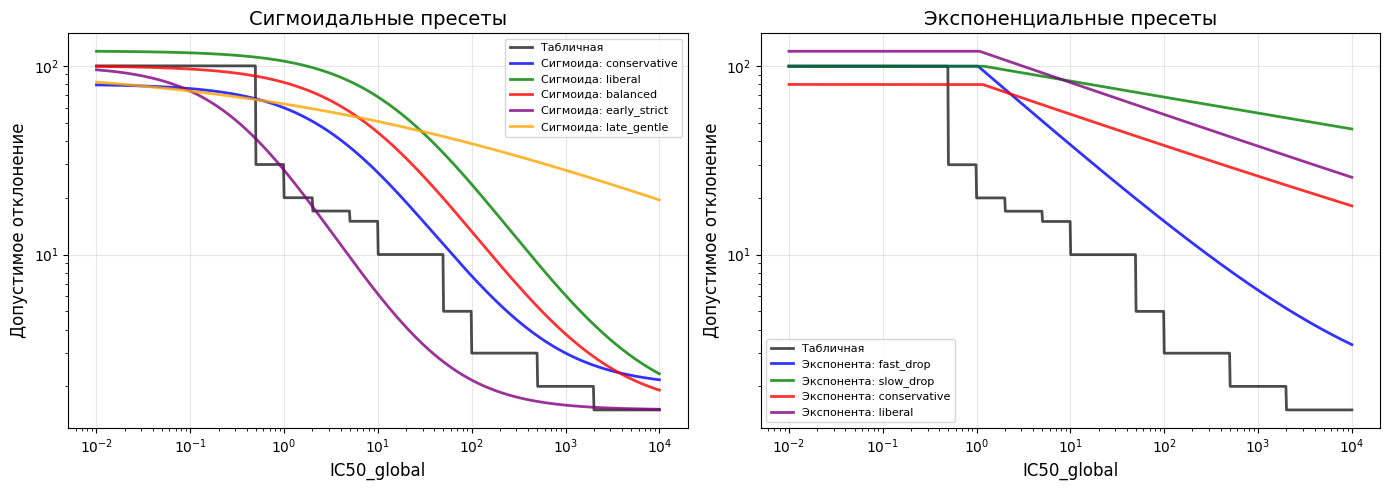

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Any, Optional

# -----------------------
# 1) ФУНКЦИИ ДОПУСТИМОГО ОТКЛОНЕНИЯ (УБЫВАЮЩИЕ!)
# -----------------------

# Старая табличная функция (убывающая по дизайну)
def calculate_allowed_fold_table(ic50_global: float) -> float:
    """Табличная шкала из исходного кода - убывающая"""
    table = [
        (0.0, 0.5, 100.0),
        (0.5, 1.0, 30.0),
        (1.0, 2.0, 20.0),
        (2.0, 5.0, 17.0),
        (5.0, 10.0, 15.0),
        (10.0, 50.0, 10.0),
        (50.0, 100.0, 5.0),
        (100.0, 500.0, 3.0),
        (500.0, 2000.0, 2.0),
        (2000.0, float("inf"), 1.5),
    ]
    for low, high, fold in table:
        if low <= ic50_global < high:
            return fold
    return 1.5

# Экспоненциальная функция - УБЫВАЮЩАЯ
def calculate_allowed_fold_exp(ic50_global: float, 
                              A: float = 100.0,     # Начальное значение (при малых IC50)
                              B: float = 0.4,      # Скорость убывания
                              C: float = 1.5) -> float:  # Конечное значение (при больших IC50)
    """Экспоненциальная убывающая функция: A * exp(-B * log10(x)) + C"""
    if ic50_global <= 0:
        return A
    
    log_x = np.log10(ic50_global)
    # Это уже убывающая функция, так как exp(-B * log_x) уменьшается с ростом x
    allowed_fold = A * np.exp(-B * log_x) + C
    # Ограничиваем между C (минимум) и A (максимум)
    allowed_fold = np.clip(allowed_fold, C, A)
    
    return float(allowed_fold)

# Сигмоидальная УБЫВАЮЩАЯ функция
def calculate_allowed_fold_sigmoid(ic50_global: float,
                                   U: float = 100.0,    # Верхнее значение (при малых IC50)
                                   L: float = 1.5,      # Нижнее значение (при больших IC50)
                                   x0_log: float = 0.0, # Точка перегиба (log10)
                                   k: float = 1.0,      # Крутизна (положительная для убывания)
                                   start_point: float = 0.5,  # Начало заметного снижения
                                   end_point: float = 100.0,  # Выход на нижнее плато
                                   use_thresholds: bool = False) -> float:
    """
    Убывающая сигмоидальная функция: 
    y = L + (U - L) / (1 + exp(k*(x - x0)))  # k>0 дает убывание
    
    Если use_thresholds=True, автоматически вычисляет x0 и k
    на основе start_point и end_point.
    """
    if ic50_global <= 0:
        return U
    
    log_x = np.log10(ic50_global)
    
    if use_thresholds:
        # Автоматическая настройка параметров на основе порогов
        log_start = np.log10(start_point)   # где начинается снижение
        log_end = np.log10(end_point)       # где достигается нижнее плато
        
        # Точка перегива посередине между порогами
        x0_log = (log_start + log_end) / 2
        
        # Крутизна обратно пропорциональна расстоянию между порогами
        # Большее расстояние = более плавный переход
        distance = log_end - log_start
        if distance > 0:
            k = 4.0 / distance  # Эмпирический коэффициент
        else:
            k = 1.0
    
    # УБЫВАЮЩАЯ сигмоида: чем больше x, тем меньше y
    # При k > 0: при x → -∞, exp(k*(x-x0)) → 0, y → U (верхнее значение)
    # При x → +∞, exp(k*(x-x0)) → +∞, y → L (нижнее значение)
    allowed_fold = L + (U - L) / (1 + np.exp(k * (log_x - x0_log)))
    
    # Ограничиваем диапазон
    allowed_fold = np.clip(allowed_fold, L, U)
    
    return float(allowed_fold)

# -----------------------
# 2) ВИЗУАЛИЗАЦИЯ С ИНТЕРАКТИВНЫМИ ЭЛЕМЕНТАМИ
# -----------------------

def create_interactive_comparison():
    """Создает интерактивное сравнение всех трех функций"""
    try:
        from ipywidgets import interact, FloatSlider, IntSlider, Checkbox, VBox, HBox, Label, ToggleButtons
        import ipywidgets as widgets
        
        # Стили для виджетов
        style = {'description_width': 'initial'}
        layout = {'width': '400px'}
        
        # Выбор типа функции для детальной настройки
        func_selector = ToggleButtons(
            options=['Экспонента', 'Сигмоида'],
            value='Экспонента',
            description='Настраиваемая функция:',
            style=style
        )
        
        # Параметры для экспоненциальной функции
        exp_A_slider = FloatSlider(
            value=100.0, min=10.0, max=200.0, step=10.0,
            description='A (макс. при малых IC50):',
            style=style, layout=layout
        )
        
        exp_B_slider = FloatSlider(
            value=0.4, min=0.1, max=2.0, step=0.1,
            description='B (скорость убывания):',
            style=style, layout=layout
        )
        
        exp_C_slider = FloatSlider(
            value=1.5, min=1.0, max=10.0, step=0.5,
            description='C (мин. при больших IC50):',
            style=style, layout=layout
        )
        
        # Параметры для сигмоиды
        sig_U_slider = FloatSlider(
            value=100.0, min=10.0, max=200.0, step=10.0,
            description='U (верхнее значение):',
            style=style, layout=layout
        )
        
        sig_L_slider = FloatSlider(
            value=1.5, min=1.0, max=10.0, step=0.5,
            description='L (нижнее значение):',
            style=style, layout=layout
        )
        
        sig_x0_slider = FloatSlider(
            value=0.0, min=-2.0, max=2.0, step=0.1,
            description='x₀ (точка перегиба в log₁₀):',
            style=style, layout=layout
        )
        
        sig_k_slider = FloatSlider(
            value=1.0, min=0.1, max=5.0, step=0.1,
            description='k (крутизна убывания):',
            style=style, layout=layout
        )
        
        # Пороги для автоматической настройки сигмоиды
        use_auto_checkbox = Checkbox(
            value=False,
            description='Автонастройка по порогам',
            style=style
        )
        
        start_slider = FloatSlider(
            value=0.5, min=0.1, max=10.0, step=0.1,
            description='Начало снижения:',
            style=style, layout=layout,
            disabled=True
        )
        
        end_slider = FloatSlider(
            value=100.0, min=10.0, max=1000.0, step=10.0,
            description='Выход на плато:',
            style=style, layout=layout,
            disabled=True
        )
        
        def update_slider_state(change):
            """Обновляет состояние слайдеров"""
            auto = change['new']
            start_slider.disabled = not auto
            end_slider.disabled = not auto
            sig_x0_slider.disabled = auto
            sig_k_slider.disabled = auto
        
        use_auto_checkbox.observe(update_slider_state, names='value')
        
        def update_visibility(change):
            """Показывает/скрывает слайдеры в зависимости от выбранной функции"""
            selected = change['new']
            if selected == 'Экспонента':
                exp_box.layout.display = 'flex'
                sig_box.layout.display = 'none'
            else:
                exp_box.layout.display = 'none'
                sig_box.layout.display = 'flex'
        
        func_selector.observe(update_visibility, names='value')
        
        # Функция для обновления графика
        def update_plot(selected_func, exp_A, exp_B, exp_C,
                       sig_U, sig_L, sig_x0, sig_k,
                       use_auto, start_thresh, end_thresh):
            
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # Генерируем данные
            x_vals = np.logspace(-2, 4, 1000)  # от 0.01 до 10000
            
            # Вычисляем значения для всех функций
            y_table = [calculate_allowed_fold_table(x) for x in x_vals]
            y_exp = [calculate_allowed_fold_exp(x, A=exp_A, B=exp_B, C=exp_C) for x in x_vals]
            
            if use_auto:
                y_sigmoid = [calculate_allowed_fold_sigmoid(
                    x, U=sig_U, L=sig_L, 
                    start_point=start_thresh, end_point=end_thresh,
                    use_thresholds=True
                ) for x in x_vals]
                sig_label = f'Сигмоида (авто: {start_thresh}→{end_thresh})'
            else:
                y_sigmoid = [calculate_allowed_fold_sigmoid(
                    x, U=sig_U, L=sig_L, x0_log=sig_x0, k=sig_k,
                    use_thresholds=False
                ) for x in x_vals]
                sig_label = f'Сигмоида (x₀=10^{sig_x0:.1f}, k={sig_k:.1f})'
            
            # График 1: Логарифмическая шкала
            ax1 = axes[0, 0]
            ax1.loglog(x_vals, y_table, 'r-', linewidth=2, label='Табличная')
            ax1.loglog(x_vals, y_exp, 'b-', linewidth=2, 
                      label=f'Экспонента (A={exp_A}, B={exp_B}, C={exp_C})')
            ax1.loglog(x_vals, y_sigmoid, 'g-', linewidth=2, label=sig_label)
            
            ax1.set_xlabel('IC50_global', fontsize=12)
            ax1.set_ylabel('Допустимое отклонение (кратное)', fontsize=12)
            ax1.set_title('Сравнение функций (логарифмическая шкала)', fontsize=14)
            ax1.grid(True, alpha=0.3)
            ax1.legend(loc='upper right', fontsize=9)
            
            # График 2: Линейная шкала (0-100)
            ax2 = axes[0, 1]
            x_vals_lin = np.linspace(0, 100, 1000)
            
            y_table_lin = [calculate_allowed_fold_table(x) for x in x_vals_lin]
            y_exp_lin = [calculate_allowed_fold_exp(x, A=exp_A, B=exp_B, C=exp_C) 
                        for x in x_vals_lin]
            
            if use_auto:
                y_sigmoid_lin = [calculate_allowed_fold_sigmoid(
                    x, U=sig_U, L=sig_L,
                    start_point=start_thresh, end_point=end_thresh,
                    use_thresholds=True
                ) for x in x_vals_lin]
            else:
                y_sigmoid_lin = [calculate_allowed_fold_sigmoid(
                    x, U=sig_U, L=sig_L, x0_log=sig_x0, k=sig_k,
                    use_thresholds=False
                ) for x in x_vals_lin]
            
            ax2.plot(x_vals_lin, y_table_lin, 'r-', linewidth=2, alpha=0.7, label='Табличная')
            ax2.plot(x_vals_lin, y_exp_lin, 'b-', linewidth=2, alpha=0.7, label='Экспонента')
            ax2.plot(x_vals_lin, y_sigmoid_lin, 'g-', linewidth=2, alpha=0.7, label='Сигмоида')
            
            # Отмечаем пороги
            if use_auto:
                ax2.axvline(x=start_thresh, color='orange', linestyle='--', 
                           alpha=0.5, label=f'Начало: {start_thresh}')
                ax2.axvline(x=end_thresh, color='purple', linestyle='--', 
                           alpha=0.5, label=f'Плато: {end_thresh}')
            
            ax2.set_xlabel('IC50_global', fontsize=12)
            ax2.set_ylabel('Допустимое отклонение (кратное)', fontsize=12)
            ax2.set_title('Сравнение функций (линейная шкала, 0-100)', fontsize=14)
            ax2.grid(True, alpha=0.3)
            ax2.legend(loc='upper right', fontsize=9)
            ax2.set_ylim(0, max(exp_A, sig_U) * 1.1)
            
            # График 3: Разница между функциями
            ax3 = axes[1, 0]
            diff_sig_table = np.array(y_sigmoid) - np.array(y_table)
            diff_exp_table = np.array(y_exp) - np.array(y_table)
            
            ax3.semilogx(x_vals, diff_sig_table, 'g-', linewidth=2, label='Сигмоида - Табличная')
            ax3.semilogx(x_vals, diff_exp_table, 'b-', linewidth=2, label='Экспонента - Табличная')
            ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            
            ax3.set_xlabel('IC50_global', fontsize=12)
            ax3.set_ylabel('Разница (кратное)', fontsize=12)
            ax3.set_title('Разница относительно табличной функции', fontsize=14)
            ax3.grid(True, alpha=0.3)
            ax3.legend(fontsize=9)
            
            # График 4: Ключевые контрольные точки
            ax4 = axes[1, 1]
            key_points = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2000]
            
            table_vals = [calculate_allowed_fold_table(x) for x in key_points]
            exp_vals = [calculate_allowed_fold_exp(x, A=exp_A, B=exp_B, C=exp_C) for x in key_points]
            sig_vals = [calculate_allowed_fold_sigmoid(
                x, U=sig_U, L=sig_L, x0_log=sig_x0, k=sig_k,
                use_thresholds=use_auto, start_point=start_thresh, end_point=end_thresh
            ) for x in key_points]
            
            x_pos = np.arange(len(key_points))
            width = 0.25
            
            ax4.bar(x_pos - width, table_vals, width, label='Табличная', color='red', alpha=0.7)
            ax4.bar(x_pos, exp_vals, width, label='Экспонента', color='blue', alpha=0.7)
            ax4.bar(x_pos + width, sig_vals, width, label='Сигмоида', color='green', alpha=0.7)
            
            ax4.set_xlabel('IC50_global', fontsize=12)
            ax4.set_ylabel('Допустимое отклонение', fontsize=12)
            ax4.set_title('Значения в ключевых точках', fontsize=14)
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels([str(x) for x in key_points], rotation=45)
            ax4.legend(fontsize=9)
            ax4.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
        
        # Создаем интерфейс
        exp_box = VBox([exp_A_slider, exp_B_slider, exp_C_slider])
        sig_box = VBox([use_auto_checkbox, 
                       HBox([sig_U_slider, sig_L_slider]),
                       HBox([sig_x0_slider, sig_k_slider]),
                       HBox([start_slider, end_slider])])
        
        # Изначально показываем только экспоненту
        sig_box.layout.display = 'none'
        
        controls_box = VBox([func_selector, exp_box, sig_box])
        
        ui = HBox([controls_box])
        
        # Создаем интерактивный виджет
        out = widgets.interactive_output(
            update_plot,
            {
                'selected_func': func_selector,
                'exp_A': exp_A_slider,
                'exp_B': exp_B_slider,
                'exp_C': exp_C_slider,
                'sig_U': sig_U_slider,
                'sig_L': sig_L_slider,
                'sig_x0': sig_x0_slider,
                'sig_k': sig_k_slider,
                'use_auto': use_auto_checkbox,
                'start_thresh': start_slider,
                'end_thresh': end_slider
            }
        )
        
        display(ui, out)
        
    except ImportError:
        print("ipywidgets не установлен. Используйте статическую визуализацию.")
        create_static_comparison()

def create_static_comparison():
    """Статическое сравнение убывающих функций"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    x_vals = np.logspace(-2, 4, 1000)
    
    # Пример 1: Все три функции (стандартные параметры)
    ax1 = axes[0, 0]
    y_table = [calculate_allowed_fold_table(x) for x in x_vals]
    y_exp = [calculate_allowed_fold_exp(x) for x in x_vals]
    y_sig = [calculate_allowed_fold_sigmoid(x) for x in x_vals]
    
    ax1.loglog(x_vals, y_table, 'r-', linewidth=2, label='Табличная')
    ax1.loglog(x_vals, y_exp, 'b-', linewidth=2, label='Экспонента (A=100, B=0.4, C=1.5)')
    ax1.loglog(x_vals, y_sig, 'g-', linewidth=2, label='Сигмоида (U=100, L=1.5, x₀=0, k=1)')
    ax1.set_title('Стандартные параметры', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8)
    
    # Пример 2: Разные крутизны сигмоиды
    ax2 = axes[0, 1]
    y_sig_steep = [calculate_allowed_fold_sigmoid(x, k=3.0) for x in x_vals]
    y_sig_smooth = [calculate_allowed_fold_sigmoid(x, k=0.3) for x in x_vals]
    
    ax2.loglog(x_vals, y_table, 'r-', linewidth=1, alpha=0.5, label='Табличная')
    ax2.loglog(x_vals, y_sig_steep, 'g-', linewidth=2, label='Крутая (k=3.0)')
    ax2.loglog(x_vals, y_sig_smooth, 'g--', linewidth=2, label='Плавная (k=0.3)')
    ax2.set_title('Влияние крутизны сигмоиды', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=8)
    
    # Пример 3: Разные точки перегиба
    ax3 = axes[0, 2]
    y_sig_early = [calculate_allowed_fold_sigmoid(x, x0_log=-1.0) for x in x_vals]  # Раннее снижение
    y_sig_late = [calculate_allowed_fold_sigmoid(x, x0_log=1.0) for x in x_vals]    # Позднее снижение
    
    ax3.loglog(x_vals, y_table, 'r-', linewidth=1, alpha=0.5, label='Табличная')
    ax3.loglog(x_vals, y_sig_early, 'g-', linewidth=2, label='Раннее (x₀=10⁻¹≈0.1)')
    ax3.loglog(x_vals, y_sig_late, 'g--', linewidth=2, label='Позднее (x₀=10¹=10)')
    ax3.set_title('Влияние точки перегиба', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=8)
    
    # Пример 4: Автоматическая настройка по разным порогам
    ax4 = axes[1, 0]
    y_sig_wide = [calculate_allowed_fold_sigmoid(x, start_point=0.1, end_point=1000.0, use_thresholds=True) for x in x_vals]
    y_sig_narrow = [calculate_allowed_fold_sigmoid(x, start_point=1.0, end_point=100.0, use_thresholds=True) for x in x_vals]
    
    ax4.loglog(x_vals, y_table, 'r-', linewidth=1, alpha=0.5, label='Табличная')
    ax4.loglog(x_vals, y_sig_wide, 'g-', linewidth=2, label='Широкий (0.1→1000)')
    ax4.loglog(x_vals, y_sig_narrow, 'g--', linewidth=2, label='Узкий (1→100)')
    ax4.set_title('Автонастройка: разные диапазоны', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=8)
    
    # Пример 5: Влияние параметров экспоненты
    ax5 = axes[1, 1]
    y_exp_fast = [calculate_allowed_fold_exp(x, B=1.0) for x in x_vals]    # Быстрое убывание
    y_exp_slow = [calculate_allowed_fold_exp(x, B=0.2) for x in x_vals]    # Медленное убывание
    
    ax5.loglog(x_vals, y_table, 'r-', linewidth=1, alpha=0.5, label='Табличная')
    ax5.loglog(x_vals, y_exp_fast, 'b-', linewidth=2, label='Быстрая (B=1.0)')
    ax5.loglog(x_vals, y_exp_slow, 'b--', linewidth=2, label='Медленная (B=0.2)')
    ax5.set_title('Влияние скорости убывания (экспонента)', fontsize=12)
    ax5.grid(True, alpha=0.3)
    ax5.legend(fontsize=8)
    
    # Пример 6: Сравнение в линейной шкале
    ax6 = axes[1, 2]
    x_vals_lin = np.linspace(0, 100, 1000)
    y_table_lin = [calculate_allowed_fold_table(x) for x in x_vals_lin]
    y_exp_lin = [calculate_allowed_fold_exp(x) for x in x_vals_lin]
    y_sig_lin = [calculate_allowed_fold_sigmoid(x, start_point=0.5, end_point=100.0, use_thresholds=True) for x in x_vals_lin]
    
    ax6.plot(x_vals_lin, y_table_lin, 'r-', linewidth=2, label='Табличная')
    ax6.plot(x_vals_lin, y_exp_lin, 'b-', linewidth=2, label='Экспонента')
    ax6.plot(x_vals_lin, y_sig_lin, 'g-', linewidth=2, label='Сигмоида (0.5→100)')
    ax6.set_title('Сравнение в линейной шкале (0-100)', fontsize=12)
    ax6.grid(True, alpha=0.3)
    ax6.legend(fontsize=8)
    ax6.set_xlabel('IC50_global')
    ax6.set_ylabel('Допустимое отклонение')
    
    plt.tight_layout()
    plt.show()

# -----------------------
# 3) ТЕСТИРОВАНИЕ ФУНКЦИЙ
# -----------------------

def test_functions():
    """Тестирует, что все функции убывающие"""
    print("Тестирование убывающих функций:")
    print("-" * 50)
    
    test_points = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2000]
    
    print("IC50\tТабличная\tЭкспонента\tСигмоида\tСтатус")
    print("-" * 60)
    
    prev_table = float('inf')
    prev_exp = float('inf')
    prev_sig = float('inf')
    
    all_decreasing = True
    
    for x in test_points:
        table_val = calculate_allowed_fold_table(x)
        exp_val = calculate_allowed_fold_exp(x)
        sig_val = calculate_allowed_fold_sigmoid(x, start_point=0.5, end_point=100.0, use_thresholds=True)
        
        # Проверяем убывание
        table_decreasing = table_val <= prev_table or abs(table_val - prev_table) < 0.1
        exp_decreasing = exp_val <= prev_exp or abs(exp_val - prev_exp) < 0.1
        sig_decreasing = sig_val <= prev_sig or abs(sig_val - prev_sig) < 0.1
        
        status = "✓" if (table_decreasing and exp_decreasing and sig_decreasing) else "✗"
        
        if not (table_decreasing and exp_decreasing and sig_decreasing):
            all_decreasing = False
        
        print(f"{x}\t{table_val:.2f}\t\t{exp_val:.2f}\t\t{sig_val:.2f}\t\t{status}")
        
        prev_table = table_val
        prev_exp = exp_val
        prev_sig = sig_val
    
    print("-" * 60)
    if all_decreasing:
        print("✅ Все функции убывающие!")
    else:
        print("❌ Некоторые функции не убывающие!")
    
    return all_decreasing

# -----------------------
# 4) ПРЕСЕТЫ ДЛЯ БЫСТРОГО ИСПОЛЬЗОВАНИЯ
# -----------------------

# Пресеты сигмоидальной функции
SIGMOID_PRESETS = {
    'conservative': {  # Консервативная (строгая) фильтрация
        'U': 80.0, 'L': 2.0, 'start_point': 0.3, 'end_point': 50.0, 'use_thresholds': True
    },
    'liberal': {  # Либеральная (мягкая) фильтрация
        'U': 120.0, 'L': 1.5, 'start_point': 1.0, 'end_point': 200.0, 'use_thresholds': True
    },
    'balanced': {  # Сбалансированная
        'U': 100.0, 'L': 1.5, 'start_point': 0.5, 'end_point': 100.0, 'use_thresholds': True
    },
    'early_strict': {  # Раннее строгое снижение
        'U': 100.0, 'L': 1.5, 'x0_log': -0.5, 'k': 2.0, 'use_thresholds': False
    },
    'late_gentle': {  # Позднее мягкое снижение
        'U': 100.0, 'L': 1.5, 'x0_log': 1.0, 'k': 0.5, 'use_thresholds': False
    }
}

# Пресеты экспоненциальной функции
EXP_PRESETS = {
    'fast_drop': {'A': 100.0, 'B': 1.0, 'C': 1.5},  # Быстрое убывание
    'slow_drop': {'A': 100.0, 'B': 0.2, 'C': 1.5},  # Медленное убывание
    'conservative': {'A': 80.0, 'B': 0.4, 'C': 2.0},  # Консервативная
    'liberal': {'A': 120.0, 'B': 0.4, 'C': 1.5},  # Либеральная
}

def create_comparison_with_presets():
    """Создает сравнение с использованием пресетов"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    x_vals = np.logspace(-2, 4, 1000)
    
    # Всегда показываем табличную функцию
    y_table = [calculate_allowed_fold_table(x) for x in x_vals]
    
    # График 1: Сигмоидальные пресеты
    ax1 = axes[0]
    ax1.loglog(x_vals, y_table, 'k-', linewidth=2, label='Табличная', alpha=0.7)
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for (name, params), color in zip(SIGMOID_PRESETS.items(), colors):
        y_sig = [calculate_allowed_fold_sigmoid(x, **params) for x in x_vals]
        ax1.loglog(x_vals, y_sig, color=color, linewidth=2, alpha=0.8, label=f'Сигмоида: {name}')
    
    ax1.set_xlabel('IC50_global', fontsize=12)
    ax1.set_ylabel('Допустимое отклонение', fontsize=12)
    ax1.set_title('Сигмоидальные пресеты', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8)
    
    # График 2: Экспоненциальные пресеты
    ax2 = axes[1]
    ax2.loglog(x_vals, y_table, 'k-', linewidth=2, label='Табличная', alpha=0.7)
    
    for (name, params), color in zip(EXP_PRESETS.items(), colors):
        y_exp = [calculate_allowed_fold_exp(x, **params) for x in x_vals]
        ax2.loglog(x_vals, y_exp, color=color, linewidth=2, alpha=0.8, label=f'Экспонента: {name}')
    
    ax2.set_xlabel('IC50_global', fontsize=12)
    ax2.set_ylabel('Допустимое отклонение', fontsize=12)
    ax2.set_title('Экспоненциальные пресеты', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

# -----------------------
# 5) ЗАПУСК
# -----------------------

if __name__ == "__main__":
    print("=" * 60)
    print("СРАВНЕНИЕ УБЫВАЮЩИХ ФУНКЦИЙ ДОПУСТИМОГО ОТКЛОНЕНИЯ")
    print("=" * 60)
    
    # Тестируем функции
    test_functions()
    
    print("\n" + "=" * 60)
    print("ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ")
    print("=" * 60)
    
    # Интерактивное сравнение
    try:
        create_interactive_comparison()
    except:
        print("Для интерактивного сравнения требуется Jupyter Notebook с ipywidgets")
        create_static_comparison()
    
    # Сравнение пресетов
    print("\n" + "=" * 60)
    print("СРАВНЕНИЕ ПРЕСЕТОВ")
    print("=" * 60)
    create_comparison_with_presets()